In [190]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import ttest_ind, ttest_1samp, f_oneway, pearsonr, spearmanr
from sklearn import set_config
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    MaxAbsScaler,
    RobustScaler,
    PolynomialFeatures,
)
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    make_scorer,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.compose import ColumnTransformer
import plotly.graph_objects as go

set_config(transform_output="pandas")

df = pd.read_csv("wine_quality_merged.csv")
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white


Le but de ce projet est de développer un modéle qui permet de dire si un vin vhino verde portuguai est rouge ou blanc avec seulement les caractéristiques physico-chimiques des vins. Dans notre projet, il est trés important de limiter les erreurs de prédictions à la fois sur les valeurs 0 et 1 car dire qu'un blanc est un rouge est autant problématique que dire qu'un rouge est un blanc. On va donc essayer d'atteindre les objectifs de score suivant: Accuracy ≥ 0,98, Precision ≥ 0,99, Recall ≥ 0,97, F1 ≥ 0,985, ROC-AUC ≥ 0,995. La premiére étape est de supprimer la varible de qualité car elle ne constitue pas une information physico-chimique.

In [191]:
df.drop("quality", axis=1, inplace=True)
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,red
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,white
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,white
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,white
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,white


Regardons maintenant si il y a des valeurs manquantes.

In [192]:
df.isna().value_counts()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  free sulfur dioxide  total sulfur dioxide  density  pH     sulphates  alcohol  type 
False          False             False        False           False      False                False                 False    False  False      False    False    6497
Name: count, dtype: int64

On observe aucune valeurs manquante.

# I) Description des variables

-fixed acidity: Concentration massique en acide tartrique (g/dm3 = g/l) - continue

-volatile acidity: Concentration massique en acide acétique (g/dm3 = g/l) - continue 

-citric acid: Concentration massique en acide citrique (g/dm3 = g/l) - continue

-residual sugar: Concentration massique en sucre résiduelle (g/dm3 = g/l) - continue

-chlorides: Concentration massique en chlorure de sodium (NaCl) (g/dm3 = g/l) - continue

-free sulfur dioxide: Concentration massique en SO2 libre (g/dm3 = g/l) - continue

-total sulfur dioxide: Concentration massique en SO2 totale (g/dm3 = g/l) - continue

-density: Densité du vin (g/cm3) - continue

-pH: pH du vin (sans unité) - continue

-sulphates: Concentrattion massique en sulfates (SO42-) (g/dm3 = g/l) - continue

-alcohol: Degrés d'alcool (% volumique) - continue

-type: Le type de vin (rouge ou blanc) - discret (target)

Maintenant, comme le vin vhino verde est un vin spéciale qui doit avoir des conditions stricte aux yeux de la loi portugaise, on doit trouver sur internet avec des sources fiables les conditions pour appelée un vin vhino verde. Voilà les conditions avec les citations.

BLANC:

-degrés d'alcool entre 8 et 14 degrés

-acidité fixe minimale de 4.5 g/l

-acidité volatile ne dépassant pas 1,08 g d’acide acétique/L

-l'acide citrique ne doit pas dépasser de 1 g/l

-La concentration en NaCl ne doit pas dépasser 1 g/l

-SO2 totale: Si le vin à <= 5 g/l de sucre résiduelle, le SO2 totale doit être inférieur à 210 mg/l. Si le sucre résiduelle est > 5g/l, le vin doit avoir moins de 300 mg/l.

-Sulfates inférieur à 2 g/l.

ROUGE:

-acidité volatile ne doit pas dépasser 1,20 g d’acide acétique/L

-SO2 totale: Si le vin à <= 5 g/l de sucre résiduelle, le SO2 totale doit être inférieur à 160 mg/l. Si le sucre résiduelle est > 5g/l, le vin doit avoir moins de 210 mg/l.

-Le reste est identique au blanc.

citations: 

-https://diariodarepublica.pt/dr/detalhe/decreto-lei/10-150313

-https://webgate.ec.europa.eu/eambrosia-api/api/v1/attachments/16925

-https://www.ivv.gov.pt/np4/89/

Supprimons maintenant les vins qui ne correspond pas à ces crtiéres.

In [193]:
# Seuils AOP utilisés (à adapter si ton référentiel évolue)
_AOP = {
    "common": {
        "alcohol_min": 8.5,
        "alcohol_max": 14.0,
        "fixed_acidity_min": 4.5,  # g/L (acide tartrique)
        "chlorides_max": 1.0,  # g/L NaCl
        "citric_acid_max": 1.0,  # g/L
    },
    "white": {
        "volatile_acidity_max": 1.08,  # g/L acide acétique
        "so2_total_max_dry": 210,  # mg/L si sucre ≤ 5 g/L
        "so2_total_max_sweet": 300,  # mg/L si sucre > 5 g/L
    },
    "red": {
        "volatile_acidity_max": 1.20,  # g/L acide acétique
        "so2_total_max_dry": 160,  # mg/L si sucre ≤ 5 g/L
        "so2_total_max_sweet": 210,  # mg/L si sucre > 5 g/L
    },
}

_REQUIRED = [
    "type",
    "alcohol",
    "fixed acidity",
    "volatile acidity",
    "residual sugar",
    "chlorides",
    "total sulfur dioxide",
    "citric acid",
]


def filter_vinho_verde_aop(
    df: pd.DataFrame, return_mask: bool = False
) -> pd.DataFrame | pd.Series:
    """
    Filtre les lignes conformes AOP Vinho Verde, blanc ou rouge.
    - df doit contenir les colonnes listées dans _REQUIRED
    - return_mask=True renvoie un masque booléen au lieu du DataFrame filtré
    """
    missing = [c for c in _REQUIRED if c not in df.columns]
    if missing:
        raise ValueError(f"Colonnes manquantes: {missing}")

    d = df.copy()
    color = d["type"].astype(str).str.lower().str.strip()

    # Règles communes
    common = (
        d["alcohol"].between(
            _AOP["common"]["alcohol_min"],
            _AOP["common"]["alcohol_max"],
            inclusive="both",
        )
        & (d["fixed acidity"] >= _AOP["common"]["fixed_acidity_min"])
        & (d["chlorides"] <= _AOP["common"]["chlorides_max"])
        & (d["citric acid"] <= _AOP["common"]["citric_acid_max"])
    )

    low_sugar = (
        d["residual sugar"] <= 5
    )  # définition "sec" opérationnelle pour les plafonds SO2

    # Blanc
    white_mask = (
        color.eq("white")
        & (d["volatile acidity"] <= _AOP["white"]["volatile_acidity_max"])
        & (
            (
                low_sugar
                & (d["total sulfur dioxide"] <= _AOP["white"]["so2_total_max_dry"])
            )
            | (
                ~low_sugar
                & (d["total sulfur dioxide"] <= _AOP["white"]["so2_total_max_sweet"])
            )
        )
    )

    # Rouge
    red_mask = (
        color.eq("red")
        & (d["volatile acidity"] <= _AOP["red"]["volatile_acidity_max"])
        & (
            (
                low_sugar
                & (d["total sulfur dioxide"] <= _AOP["red"]["so2_total_max_dry"])
            )
            | (
                ~low_sugar
                & (d["total sulfur dioxide"] <= _AOP["red"]["so2_total_max_sweet"])
            )
        )
    )

    mask = common & (white_mask | red_mask)
    return mask if return_mask else df[mask].copy()


df = filter_vinho_verde_aop(df)
len(df)

6443

In [194]:
6497 - 6443

54

Dans ce jeu de données, 54 vin ne sont plus considérée aujourd'hui comme des vins vhino verde. On observe que les concentration en SO2 ainsi que la densité ne sont exprimée à la même unité que les autres concentrations. On va donc faire les conversions.

In [195]:
df["free sulfur dioxide"] *= 0.001
df["total sulfur dioxide"] *= 0.001
df["density"] *= 1000

df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,7.4,0.70,0.00,1.9,0.076,0.011,0.034,997.80,3.51,0.56,9.4,red
1,7.8,0.88,0.00,2.6,0.098,0.025,0.067,996.80,3.20,0.68,9.8,red
2,7.8,0.76,0.04,2.3,0.092,0.015,0.054,997.00,3.26,0.65,9.8,red
3,11.2,0.28,0.56,1.9,0.075,0.017,0.060,998.00,3.16,0.58,9.8,red
4,7.4,0.70,0.00,1.9,0.076,0.011,0.034,997.80,3.51,0.56,9.4,red
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,0.024,0.092,991.14,3.27,0.50,11.2,white
6493,6.6,0.32,0.36,8.0,0.047,0.057,0.168,994.90,3.15,0.46,9.6,white
6494,6.5,0.24,0.19,1.2,0.041,0.030,0.111,992.54,2.99,0.46,9.4,white
6495,5.5,0.29,0.30,1.1,0.022,0.020,0.110,988.69,3.34,0.38,12.8,white


In [196]:
train_set, test_set = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
)
train_set

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
2618,8.3,0.14,0.26,1.5,0.049,0.056,0.189,994.60,3.21,0.62,9.5,white
2359,6.9,0.18,0.38,8.1,0.049,0.044,0.176,995.80,3.30,0.54,9.8,white
4924,6.8,0.25,0.28,5.0,0.035,0.042,0.126,990.48,3.12,0.38,12.6,white
6351,5.1,0.25,0.36,1.3,0.035,0.040,0.078,989.10,3.23,0.64,12.1,white
153,7.5,0.60,0.03,1.8,0.095,0.025,0.099,995.00,3.35,0.54,10.1,red
...,...,...,...,...,...,...,...,...,...,...,...,...
3803,7.6,0.27,0.33,2.0,0.059,0.019,0.175,994.40,3.22,0.56,9.9,white
5232,6.6,0.30,0.25,8.0,0.036,0.021,0.124,993.62,3.06,0.38,10.8,white
5267,6.5,0.27,0.26,11.0,0.030,0.002,0.082,994.02,3.07,0.36,11.2,white
5431,6.8,0.31,0.19,3.5,0.086,0.030,0.130,993.00,2.83,0.44,9.6,white



# II) Analyse statistiques

## II.1) Analyse des effecctifs du type de vin.

In [197]:
train_set["type"].value_counts()

type
white    3903
red      1251
Name: count, dtype: int64

On observe qu'il y a plus de vin blanc que de vin rouge. On va donc utiliser comme métrique un f1_score pour choisir un modéle avec GridSearchCV mais on doit comme on a dit avoir au moins 99% pour chaque métriques mentionné. Il est connue que le raisin blanc à plus de sucre que le rouge donc on peut avoir potentiellement avoir plus de sucre résiduelle dans les vins blancs que dans les rouges. Il est aussi connue que les blancs contienne plus de de SO2 et de sulfates et généralement les vin rouge sont plus alcoolisé que les vins blancs. On va donc commencer notre analyse exploratoire en analysant ces information. Pour chaque variable on va faire une analyse 

## II.2) Analyse des variables potentiellement intéréssantes

### II.2.1) Analyse univarié

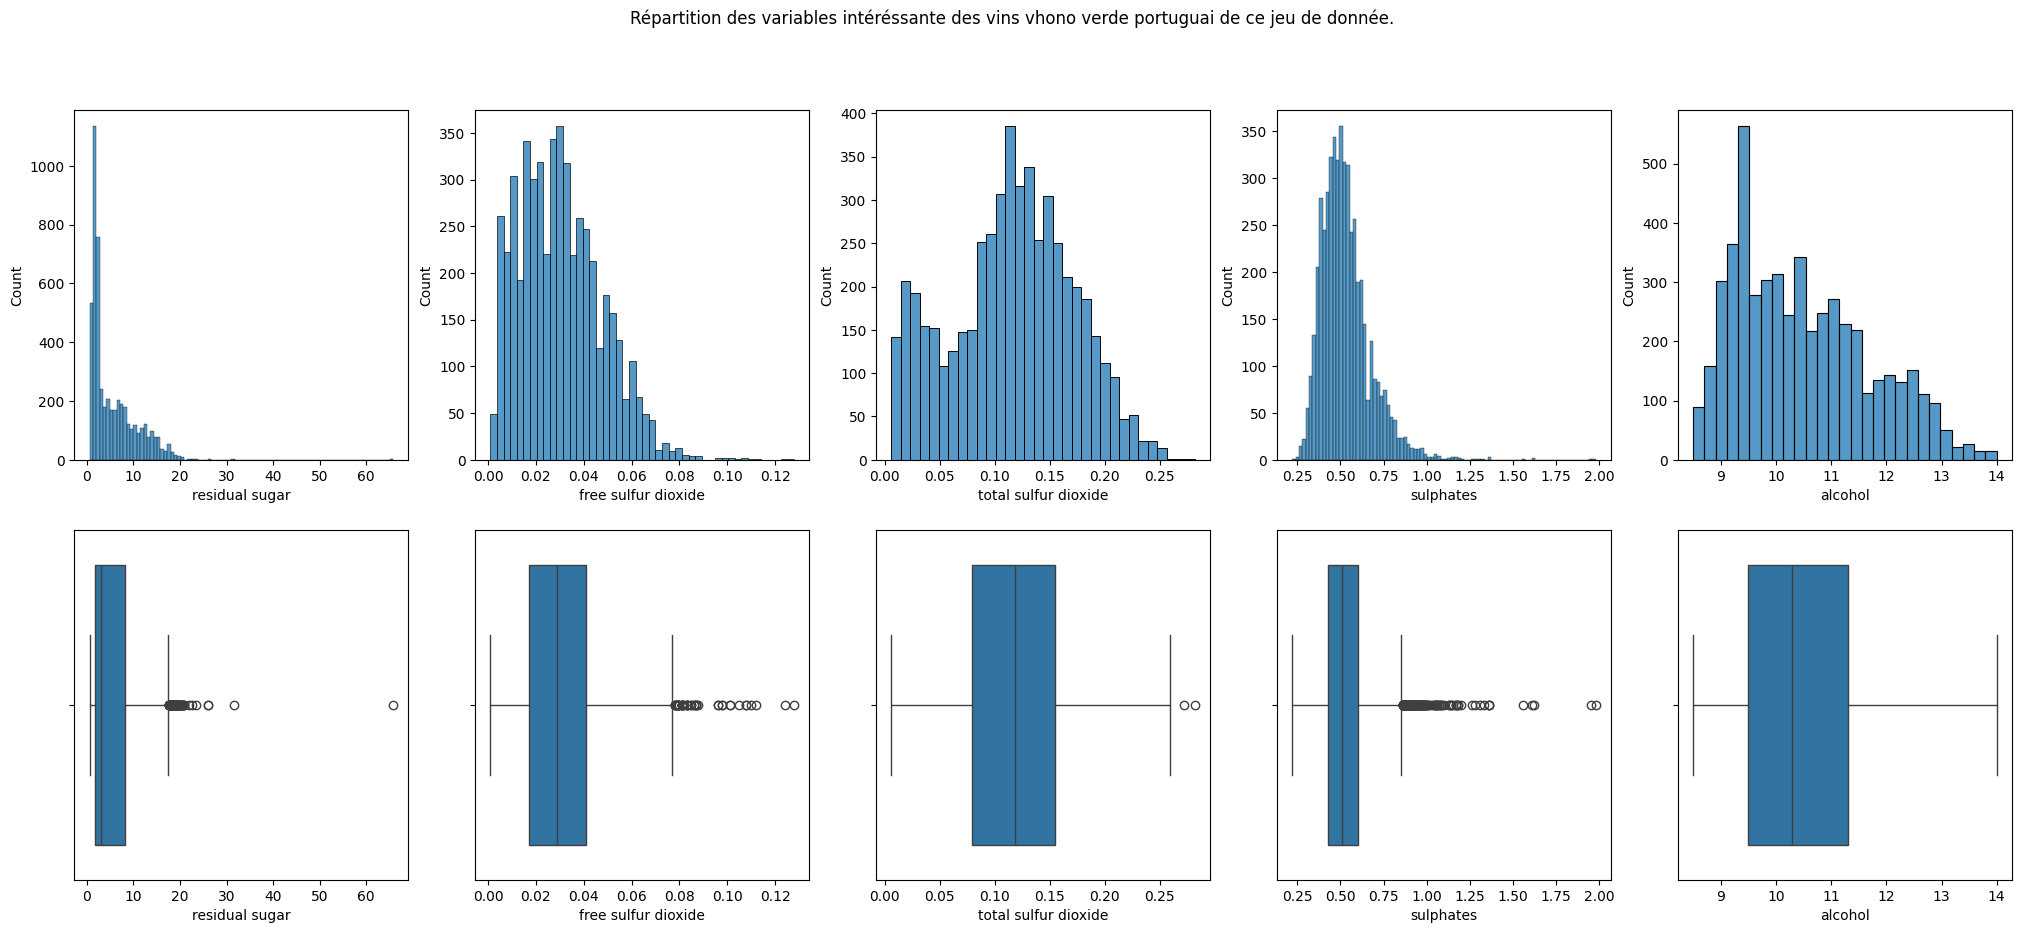

,residual sugar,free sulfur dioxide,total sulfur dioxide,sulphates,alcohol
count,5154.000000,5154.000000,5154.000000,5154.000000,5154.000000
mean,5.490114,0.030383,0.115612,0.530691,10.489071
std,4.789739,0.017169,0.055617,0.145428,1.183210
min,0.600000,0.001000,0.006000,0.220000,8.500000
25%,1.800000,0.017000,0.079000,0.430000,9.500000
50%,3.100000,0.029000,0.118000,0.510000,10.300000
75%,8.100000,0.041000,0.155000,0.600000,11.300000
max,65.800000,0.128000,0.282000,1.980000,14.000000


In [198]:
fig, ax = plt.subplots(2, 5)
fig.set_size_inches(25, 10)
plt.suptitle(
    "Répartition des variables intéréssante des vins vhono verde portuguai de ce jeu de donnée."
)
sns.histplot(data=train_set, x="residual sugar", ax=ax[0, 0])
sns.boxplot(data=train_set, x="residual sugar", ax=ax[1, 0])
sns.histplot(data=train_set, x="free sulfur dioxide", ax=ax[0, 1])
sns.boxplot(data=train_set, x="free sulfur dioxide", ax=ax[1, 1])
sns.histplot(data=train_set, x="total sulfur dioxide", ax=ax[0, 2])
sns.boxplot(data=train_set, x="total sulfur dioxide", ax=ax[1, 2])
sns.histplot(data=train_set, x="sulphates", ax=ax[0, 3])
sns.boxplot(data=train_set, x="sulphates", ax=ax[1, 3])
sns.histplot(data=train_set, x="alcohol", ax=ax[0, 4])
sns.boxplot(data=train_set, x="alcohol", ax=ax[1, 4])
plt.show()
train_set[
    [
        "residual sugar",
        "free sulfur dioxide",
        "total sulfur dioxide",
        "sulphates",
        "alcohol",
    ]
].describe()

Les vins vhino verde portuguai de ce jeu de donnée ont en moyenne 5.472 g/l de sucre résiduelle, 0.031 g/l de SO2 libre, 0.116 g/l de SO2 total, 0.531 g/l de sulfates et ont un degrés d'alcool de 10.484°. On observe que seul la concentration en sucre résiduelle ne suit pas une loi normale. On observe un vin beaucoup plus concentré en sucre résiduelle qui est considérée comme un outlier mais cela ne veut rien dire. Au delà de 45 g/l de sucre résiduel, le vin est du style vendange tardive. Il éxiste d'autre outliers pour le sucre résiduelle et les autres variables mais elles sont proche les uns des autre. 

### II.2.2) Analyse multivarié avec la target

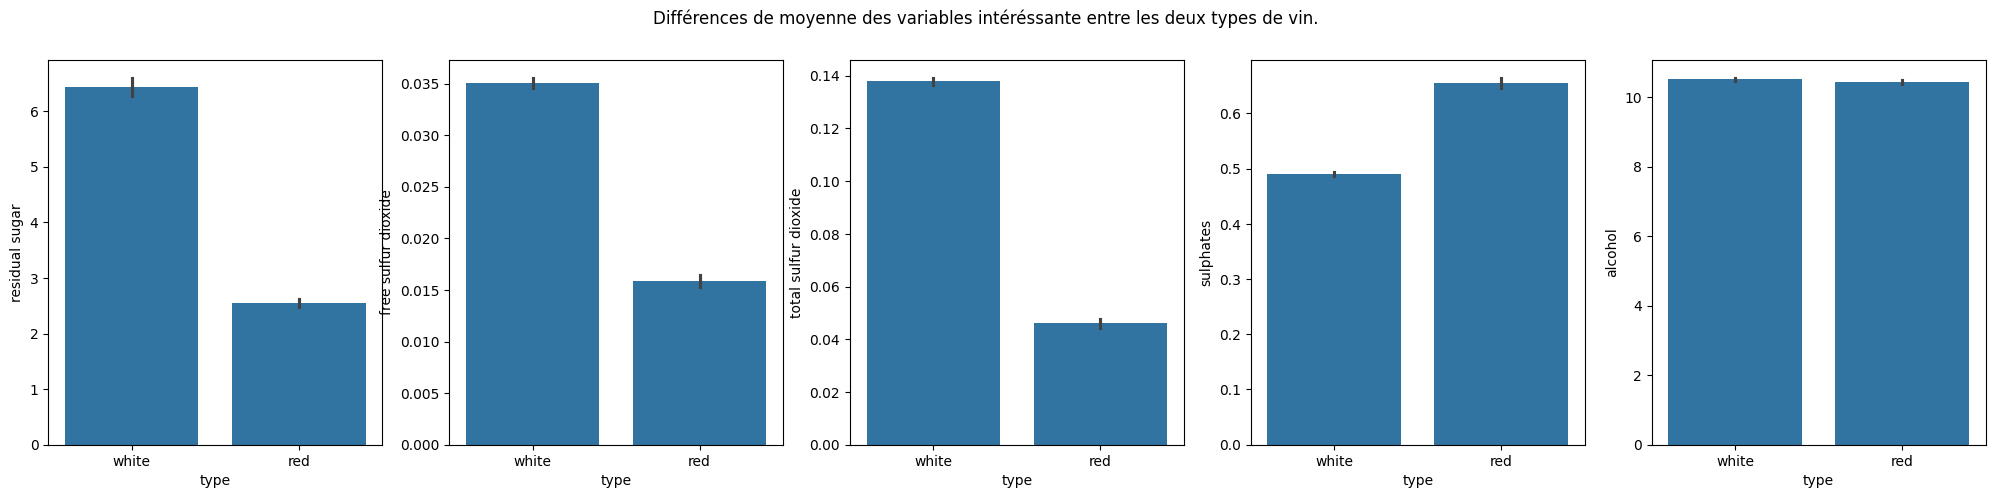

In [199]:
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(25, 5)
plt.suptitle(
    "Différences de moyenne des variables intéréssante entre les deux types de vin."
)
sns.barplot(data=train_set, y="residual sugar", x="type", ax=ax[0])
sns.barplot(data=train_set, y="free sulfur dioxide", x="type", ax=ax[1])
sns.barplot(data=train_set, y="total sulfur dioxide", x="type", ax=ax[2])
sns.barplot(data=train_set, y="sulphates", x="type", ax=ax[3])
sns.barplot(data=train_set, y="alcohol", x="type", ax=ax[4])
plt.show()

On observe que les vins blanc vhino verde ont en moyenne plus de sucre résiduelle, de SO2 libre et totale mais moins de sulfates que les vins rouges. Il y a en moyenne un degré d'alcool similaires pour les deux types. Passons aux répartitions. 

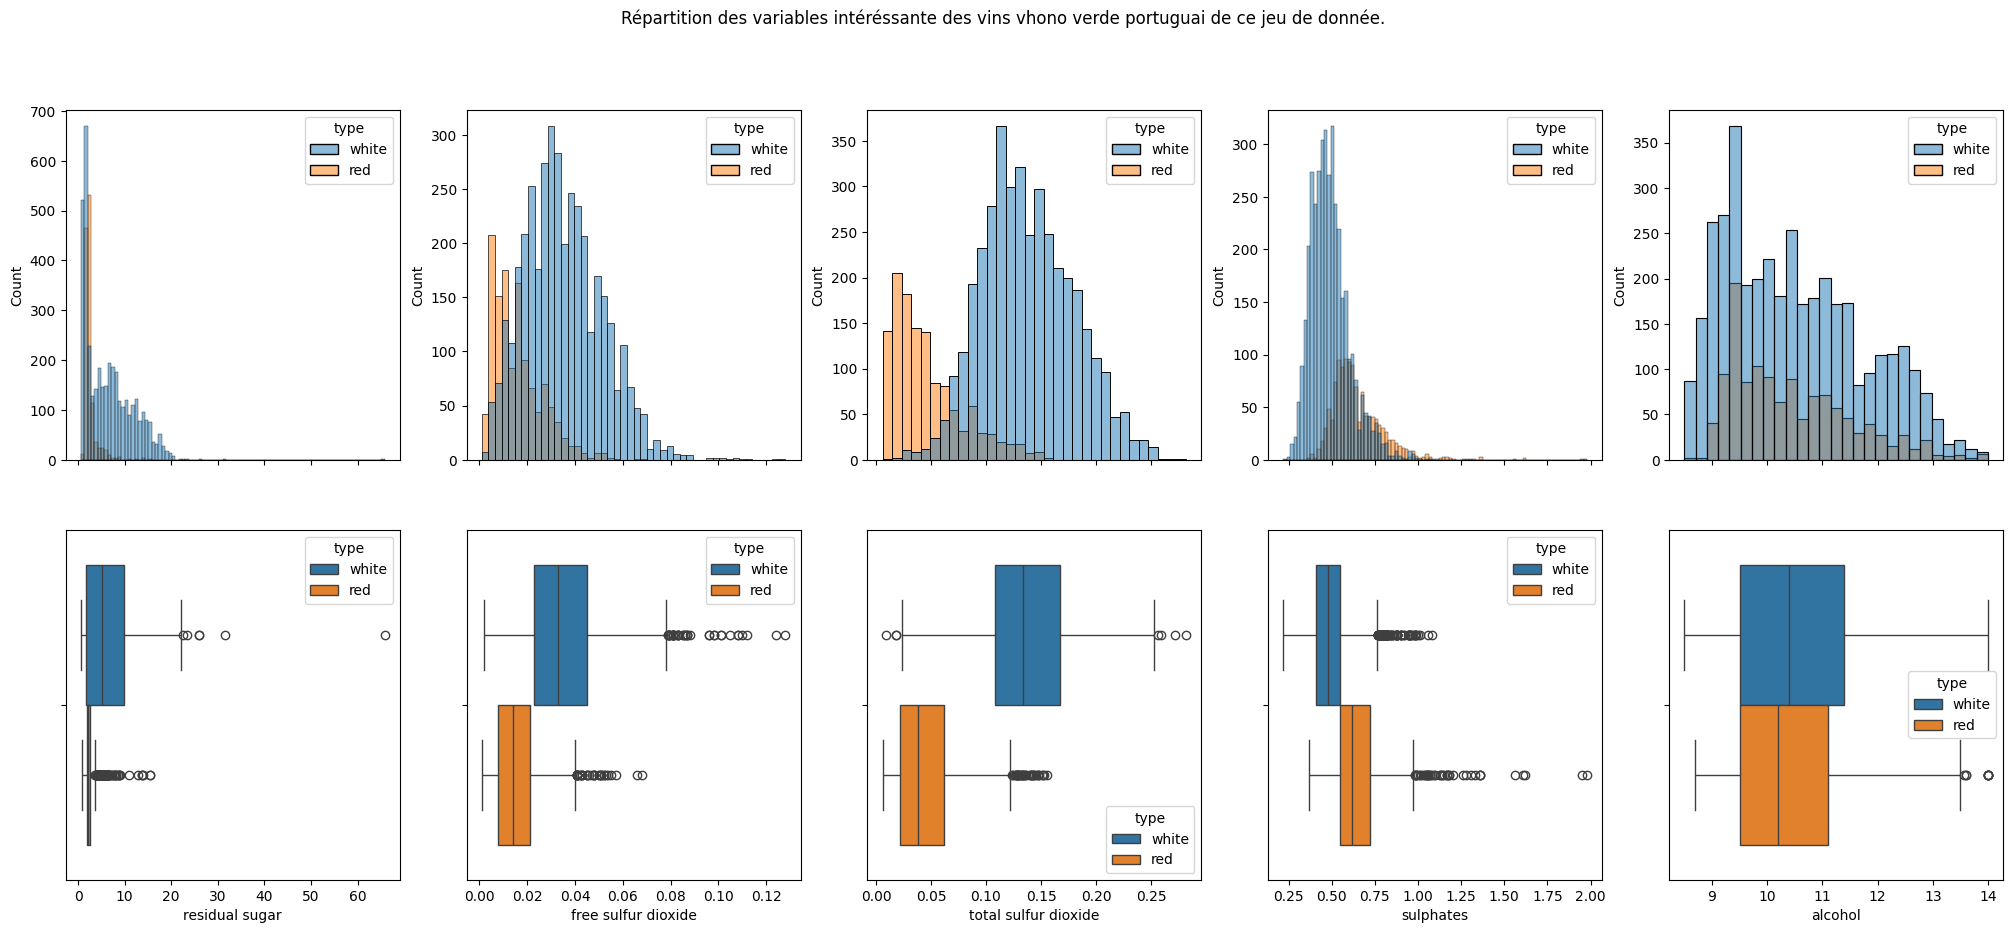

In [200]:
fig, ax = plt.subplots(2, 5, sharex="col")
fig.set_size_inches(25, 10)
plt.suptitle(
    "Répartition des variables intéréssante des vins vhono verde portuguai de ce jeu de donnée."
)
sns.histplot(data=train_set, x="residual sugar", hue="type", ax=ax[0, 0])
sns.boxplot(data=train_set, x="residual sugar", hue="type", ax=ax[1, 0])
sns.histplot(data=train_set, x="free sulfur dioxide", hue="type", ax=ax[0, 1])
sns.boxplot(data=train_set, x="free sulfur dioxide", hue="type", ax=ax[1, 1])
sns.histplot(data=train_set, x="total sulfur dioxide", hue="type", ax=ax[0, 2])
sns.boxplot(data=train_set, x="total sulfur dioxide", hue="type", ax=ax[1, 2])
sns.histplot(data=train_set, x="sulphates", hue="type", ax=ax[0, 3])
sns.boxplot(data=train_set, x="sulphates", hue="type", ax=ax[1, 3])
sns.histplot(data=train_set, x="alcohol", hue="type", ax=ax[0, 4])
sns.boxplot(data=train_set, x="alcohol", hue="type", ax=ax[1, 4])
plt.show()

On observe que les deux histogrammes et boxplots pour les quatres premiére variables sont décalés et on commence à voir une séparation. Par contre pour le cas de l'alcool on a une superposition totale des deux histogrammes ainsi que des boxplots. On commence à avoir une belle séparation avec la concentration totale en SO2. Avant de passer aux tests d'hypothéses il faut validé les conditions d'utilisation.

In [201]:
train_set.groupby("type")[
    [
        "residual sugar",
        "free sulfur dioxide",
        "total sulfur dioxide",
        "sulphates",
        "alcohol",
    ]
].std()

,residual sugar,free sulfur dioxide,total sulfur dioxide,sulphates,alcohol
type,,,,,
red,1.382819,0.010302,0.031533,0.16065,1.054768
white,5.100361,0.016305,0.041494,0.11453,1.221067


1: Tous les caractéristiques physico-chimiques de ce jeu de données pour un vin ne dépends pas des autres.

2: Ce sont tous des vins de type vhino verde portuguai. Ils sont par conséquent tous issues de la même population.

3: Il y a plus de 30 points par catégorie de la target

4: On voit que la différence d'écart-types est trop grande pour utiliser un test de student pour le sucre résiduel mais pas pour les autres variables.

In [202]:
print(
    "H0: Les vins rouge ont en moyenne la même concentration en sucre que les vins blanc."
)

alpha = 0.02

p_value = ttest_ind(
    train_set.query("`type` == 'red'")["residual sugar"],
    train_set.query("`type` == 'white'")["residual sugar"],
    equal_var=False,
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les vins rouge ont en moyenne la même concentration en sucre que les vins blanc.
Nous avons assez d'évidence pour rejeter H0.


In [203]:
print(
    "H0: Les vins rouge ont en moyenne la même concentration en SO2 libre que les vins blanc."
)

alpha = 0.02

p_value = ttest_ind(
    train_set.query("`type` == 'red'")["free sulfur dioxide"],
    train_set.query("`type` == 'white'")["free sulfur dioxide"],
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les vins rouge ont en moyenne la même concentration en SO2 libre que les vins blanc.
Nous avons assez d'évidence pour rejeter H0.


In [204]:
print(
    "H0: Les vins rouge ont en moyenne la même concentration en SO2 total que les vins blanc."
)

alpha = 0.02

p_value = ttest_ind(
    train_set.query("`type` == 'red'")["total sulfur dioxide"],
    train_set.query("`type` == 'white'")["total sulfur dioxide"],
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les vins rouge ont en moyenne la même concentration en SO2 total que les vins blanc.
Nous avons assez d'évidence pour rejeter H0.


In [205]:
print(
    "H0: Les vins rouge ont en moyenne la même concentration en sulfates que les vins blanc."
)

alpha = 0.02

p_value = ttest_ind(
    train_set.query("`type` == 'red'")["sulphates"],
    train_set.query("`type` == 'white'")["sulphates"],
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les vins rouge ont en moyenne la même concentration en sulfates que les vins blanc.
Nous avons assez d'évidence pour rejeter H0.


In [206]:
print("H0: Les vins rouge ont en moyenne lae même degrés d'alcool que les vins blanc.")

alpha = 0.02

p_value = ttest_ind(
    train_set.query("`type` == 'red'")["alcohol"],
    train_set.query("`type` == 'white'")["alcohol"],
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les vins rouge ont en moyenne lae même degrés d'alcool que les vins blanc.
Nous n'avons pas assez d'évidence pour rejeter H0.


Sans surprise on a rejeter H0 pour les la concentratioon en sucre résiduelle, SO2 libre et totale et concentration en sulfate. On n'a pas réussi à rejeter H0 pour l'alcool. Par conséquent on pourrat supprimer cette variable durant le préprocéssing.

### II.2.3) Analyse des variables intéréssante entre-eux.

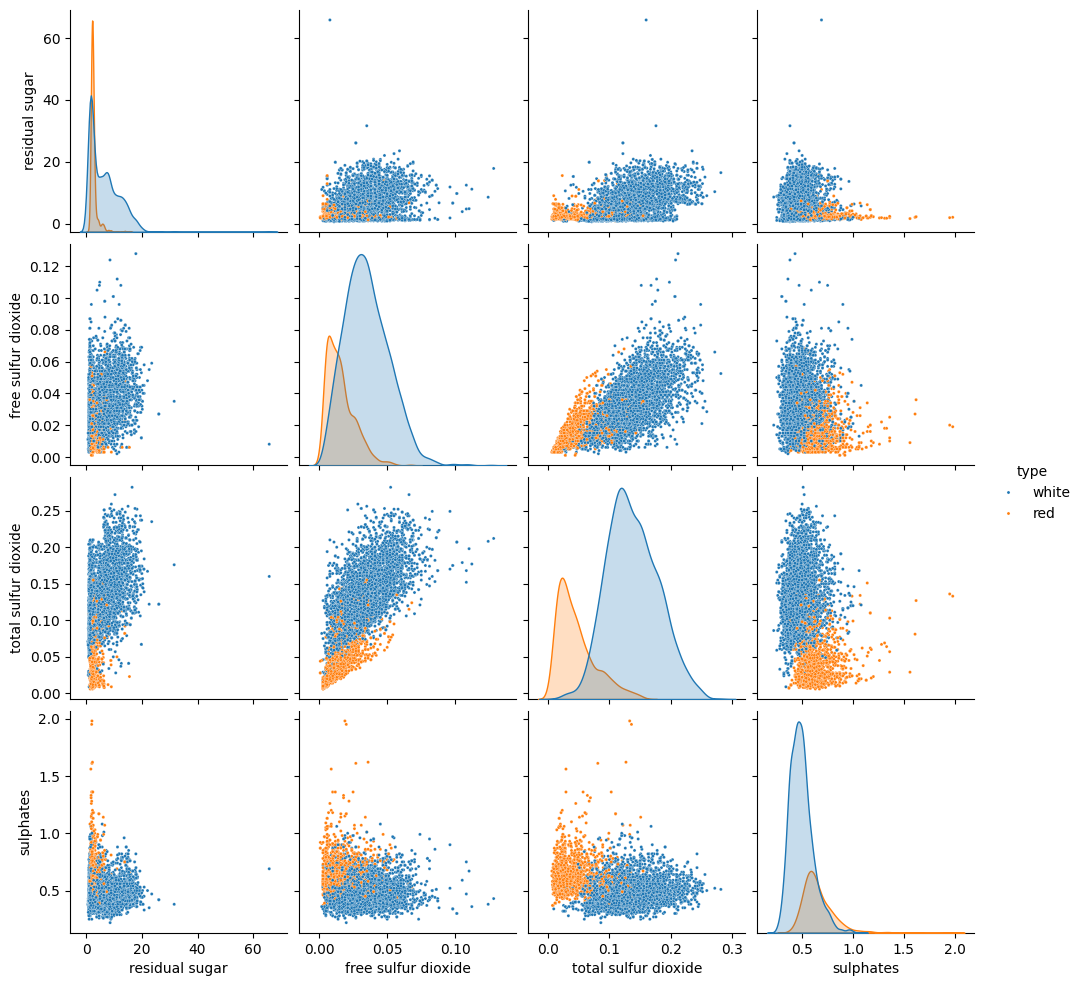

In [207]:
fig = sns.pairplot(
    train_set[
        [
            "residual sugar",
            "free sulfur dioxide",
            "total sulfur dioxide",
            "sulphates",
            "type",
        ]
    ],
    hue="type",
    plot_kws={"s": 5},
)
plt.show()

On observe qu'on commence à avoir une séparation intéréssante avec les relations entre "free sulfur dioxide" et "total sulfur dioxide" et entre "sulpahtes" et "total sulfur dioxide". Faisons un zoom des deux relations.

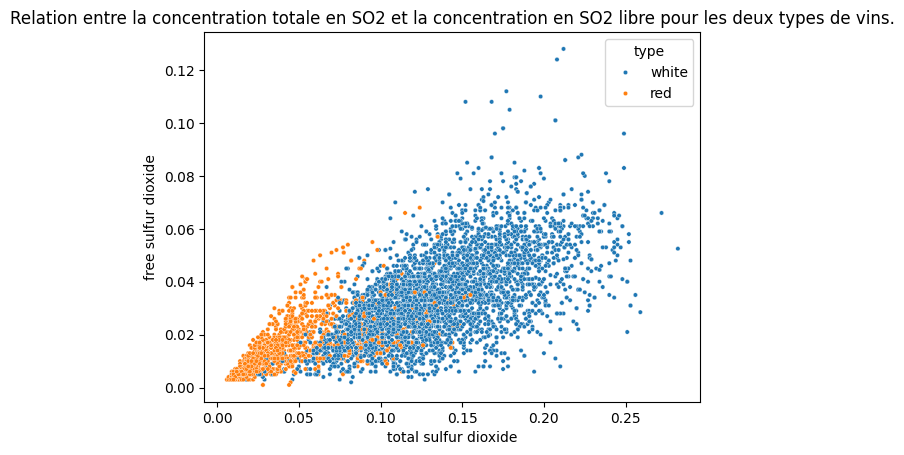

In [208]:
sns.scatterplot(
    data=train_set, x="total sulfur dioxide", y="free sulfur dioxide", hue="type", s=10
)
plt.title(
    "Relation entre la concentration totale en SO2 et la concentration en SO2 libre pour les deux types de vins."
)
plt.show()

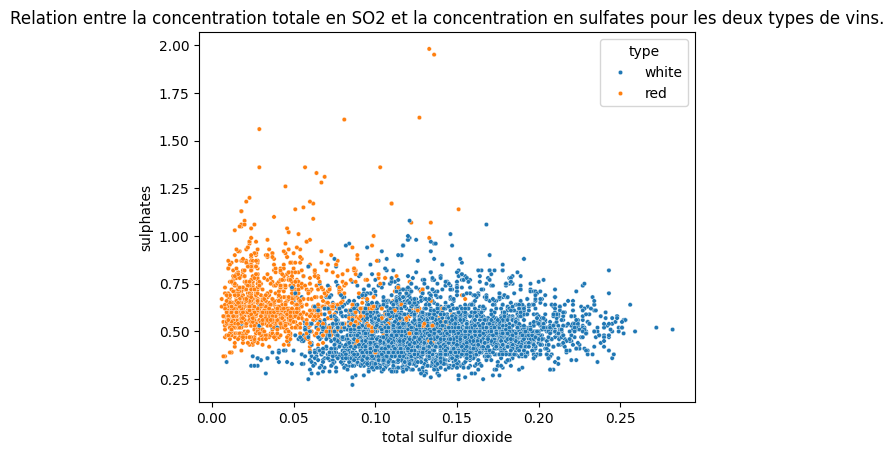

In [209]:
sns.scatterplot(
    data=train_set, x="total sulfur dioxide", y="sulphates", hue="type", s=10
)
plt.title(
    "Relation entre la concentration totale en SO2 et la concentration en sulfates pour les deux types de vins."
)
plt.show()

On peut déjà commencer à faire un trés bon modéle avec les deux surfaces précédente. Maitenant regardons la surface 3D entrela concentration en sulfates, SO2 libre et SO2 totale.

In [210]:
fig = px.scatter_3d(
    train_set,
    x="total sulfur dioxide",
    y="free sulfur dioxide",
    z="sulphates",
    color="type",
)
fig.update_traces(
    marker=dict(size=4, line=dict(width=2)),
    selector=dict(mode="markers"),
)
fig.update_layout(
    title_text="Relation entre la concentration en sulfates, SO2 libre et SO2 totale pour les deux types de vins",
    title_x=0.5,
)

On voit qu'on peut commencer à avoir un assez bon modéles avec ces trois variables mais il y a encore de la superposition. On va donc continuer à analyser les autres variables.

## II.3) Analyse des variables d'acidité

### II.3.1) Analyse univarié

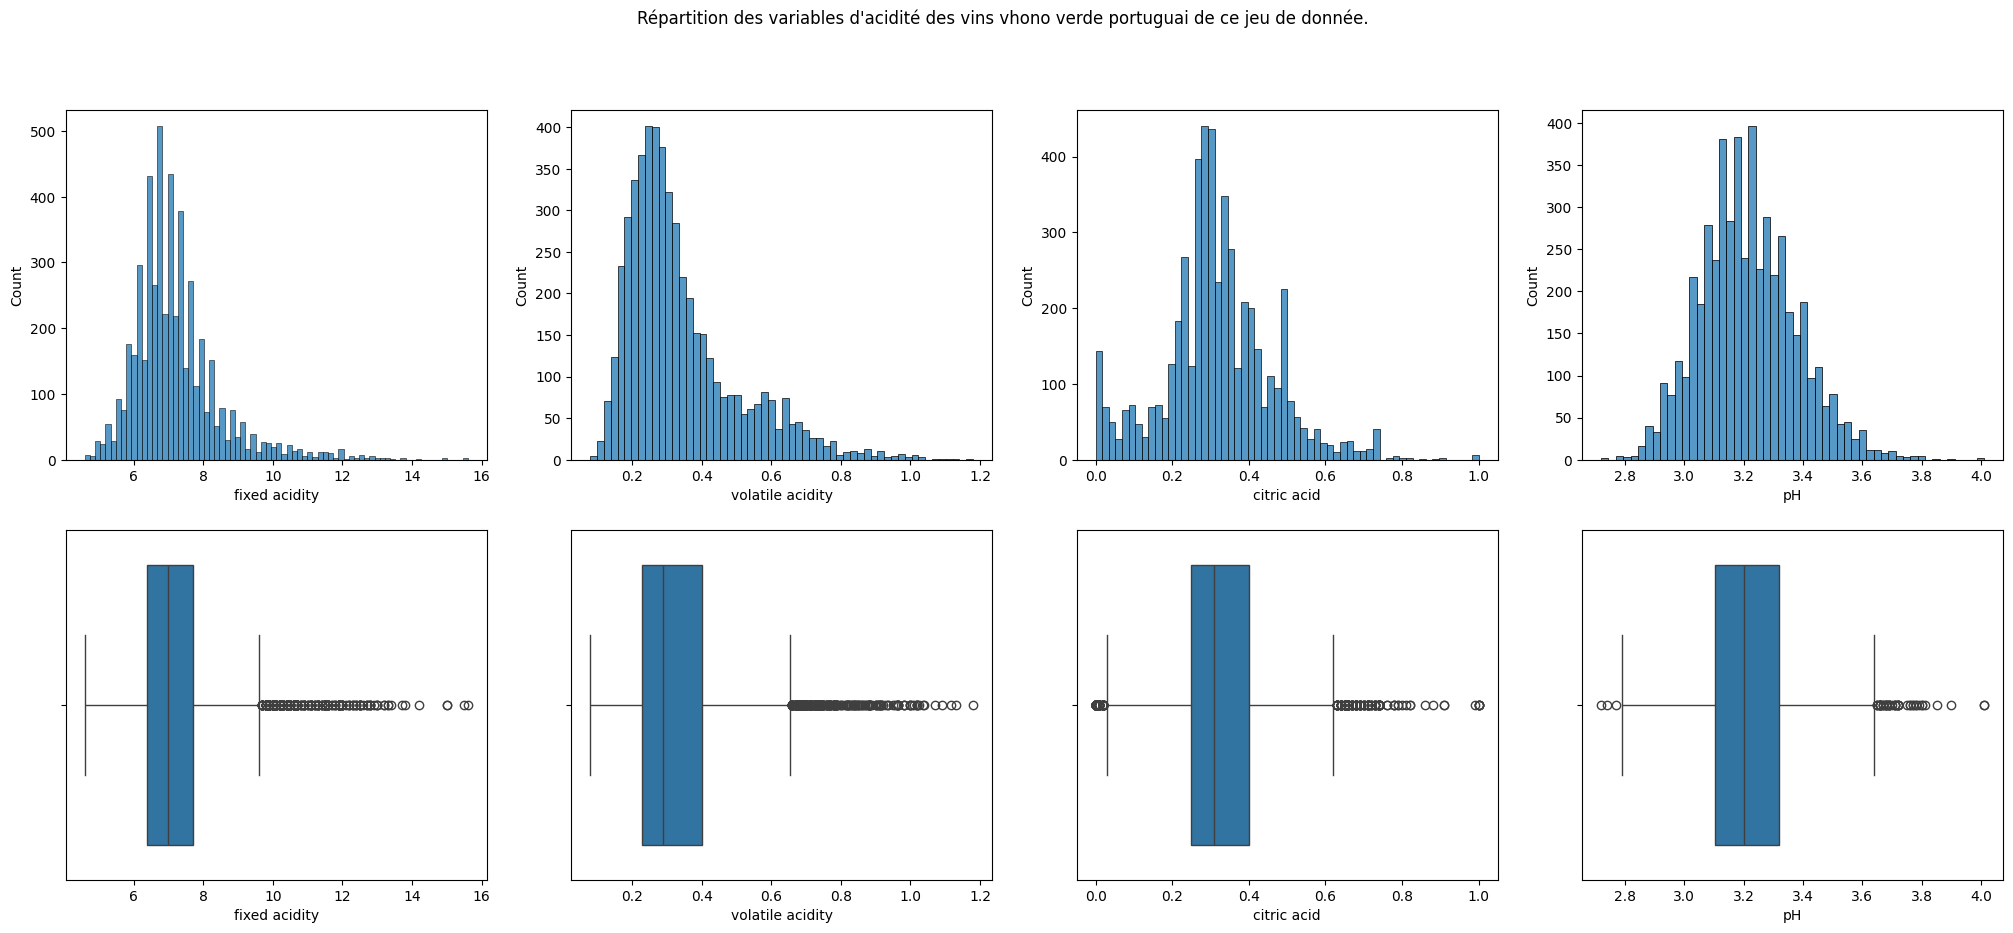

,fixed acidity,volatile acidity,citric acid,pH
count,5154.000000,5154.000000,5154.000000,5154.000000
mean,7.209682,0.338154,0.318694,3.216013
std,1.265865,0.162633,0.143715,0.161007
min,4.600000,0.080000,0.000000,2.720000
25%,6.400000,0.230000,0.250000,3.102500
50%,7.000000,0.290000,0.310000,3.200000
75%,7.700000,0.400000,0.400000,3.320000
max,15.600000,1.180000,1.000000,4.010000


In [211]:
fig, ax = plt.subplots(2, 4)
fig.set_size_inches(25, 10)
plt.suptitle(
    "Répartition des variables d'acidité des vins vhono verde portuguai de ce jeu de donnée."
)
sns.histplot(data=train_set, x="fixed acidity", ax=ax[0, 0])
sns.boxplot(data=train_set, x="fixed acidity", ax=ax[1, 0])
sns.histplot(data=train_set, x="volatile acidity", ax=ax[0, 1])
sns.boxplot(data=train_set, x="volatile acidity", ax=ax[1, 1])
sns.histplot(data=train_set, x="citric acid", ax=ax[0, 2])
sns.boxplot(data=train_set, x="citric acid", ax=ax[1, 2])
sns.histplot(data=train_set, x="pH", ax=ax[0, 3])
sns.boxplot(data=train_set, x="pH", ax=ax[1, 3])
plt.show()
train_set[
    [
        "fixed acidity",
        "volatile acidity",
        "citric acid",
        "pH",
    ]
].describe()

Les vins vhino verde portugai rouge et blanc de ce jeu de données ont en moyenne 7.210 g/l d'acidité fixe, 0.338 g/l d'acidité volatile, 0.319 g/l d'acide citrique et un pH moyen de 3.216 qui est un pH acide. On voit que certain vin n'ont pas d'acide citrique. Les quatre variables d'acidité suivent une loi normale. On observe des outliers relativement proche de la boite et proche les uns des autres.

### II.3.2) Analyse des variables d'acidité avec le type de vin.

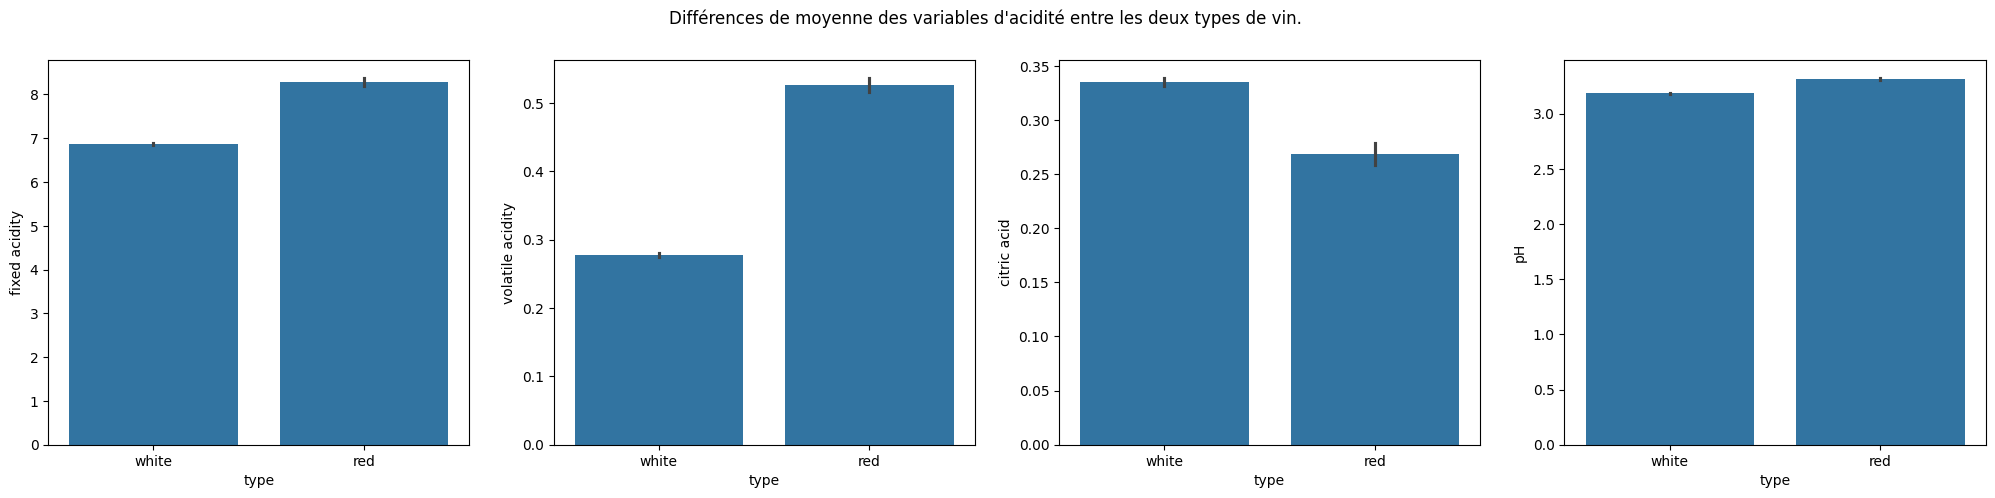

In [212]:
fig, ax = plt.subplots(1, 4)
fig.set_size_inches(25, 5)
plt.suptitle(
    "Différences de moyenne des variables d'acidité entre les deux types de vin."
)
sns.barplot(data=train_set, y="fixed acidity", x="type", ax=ax[0])
sns.barplot(data=train_set, y="volatile acidity", x="type", ax=ax[1])
sns.barplot(data=train_set, y="citric acid", x="type", ax=ax[2])
sns.barplot(data=train_set, y="pH", x="type", ax=ax[3])
plt.show()

On voit qu'il y a en moyenne une concentration plus élevé en acide tartrique (acidité fixe) et en acide citrique dans les blanc que dans les rouges. Il y a en moyenne une concentration plus élevé en acide acétique (acidité volatile) et un pH plus élevé pour les vins rouge que les vins blancs. On voit que la plus grande différence s'observe avec la concentration en acide acétique et on voit que la différence la plus faible est pour le pH ce qui est normale car le vin est une solution tampon donc le pH ne doit pas beaucoup varié entre les deux types de vins.

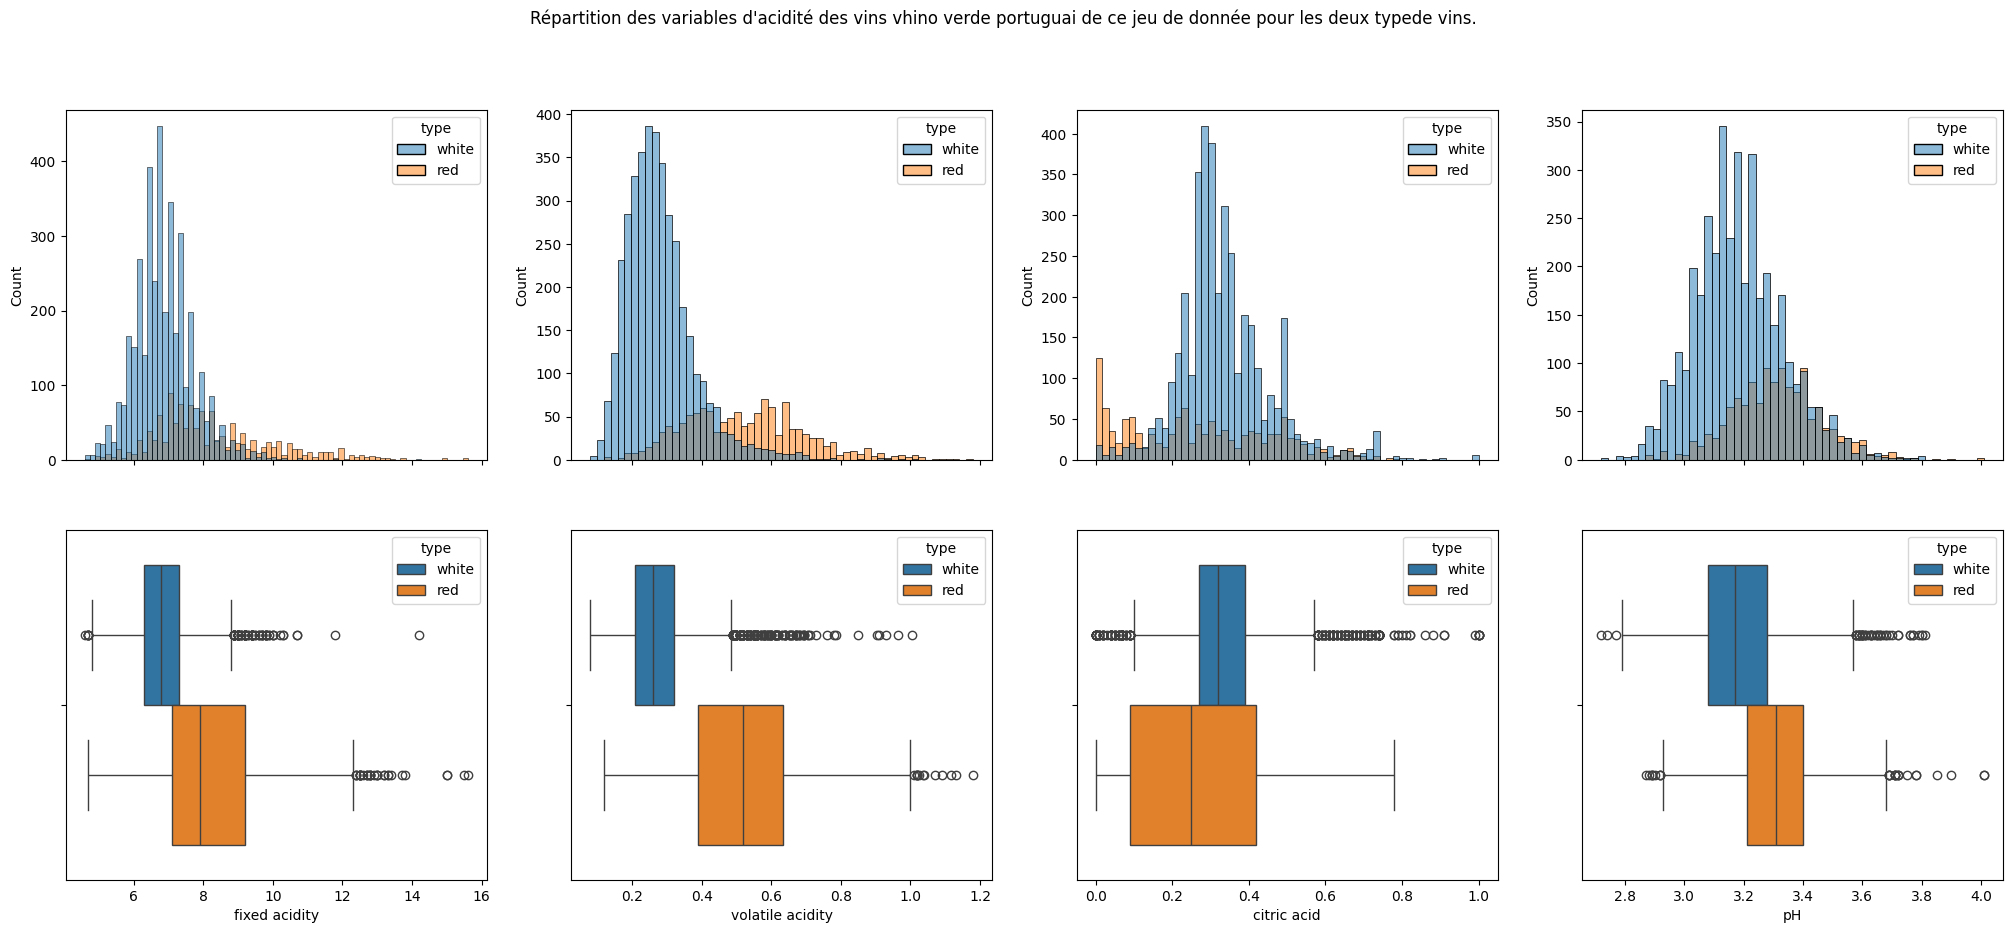

In [213]:
fig, ax = plt.subplots(2, 4, sharex="col")
fig.set_size_inches(25, 10)
plt.suptitle(
    "Répartition des variables d'acidité des vins vhino verde portuguai de ce jeu de donnée pour les deux typede vins."
)
sns.histplot(data=train_set, x="fixed acidity", hue="type", ax=ax[0, 0])
sns.boxplot(data=train_set, x="fixed acidity", hue="type", ax=ax[1, 0])
sns.histplot(data=train_set, x="volatile acidity", hue="type", ax=ax[0, 1])
sns.boxplot(data=train_set, x="volatile acidity", hue="type", ax=ax[1, 1])
sns.histplot(data=train_set, x="citric acid", hue="type", ax=ax[0, 2])
sns.boxplot(data=train_set, x="citric acid", hue="type", ax=ax[1, 2])
sns.histplot(data=train_set, x="pH", hue="type", ax=ax[0, 3])
sns.boxplot(data=train_set, x="pH", hue="type", ax=ax[1, 3])
plt.show()

On observe qu'il y a des différences intéréssante dans les répartitions pour les variables d'acidité fixe et surtout volatile. On voit que les vins rouges ont un domaine de définition plus grand que les vins blancs pour les trois concetrations en acide. Même si il y a une superposition des deux histogrammes pour le pH, on observe un décalage entre les deux répartition mais elle est quand même la variable la moins intéréssantes de toutes les variables d'acidité. Faisons les test d'hypothéses.

In [214]:
train_set.groupby("type")[
    ["fixed acidity", "volatile acidity", "citric acid", "pH"]
].std()

,fixed acidity,volatile acidity,citric acid,pH
type,,,,
red,1.697722,0.174866,0.191821,0.153235
white,0.841789,0.100777,0.120057,0.150334


Globalement toutes les différences d'écart-type sont suffisamment proche pour utiliser le test de student. Les autres conditions ont déjà été vérifié.

In [215]:
print("H0: Les vins rouge ont en moyenne la même acidité fixe que les vins blanc.")

alpha = 0.02

p_value = ttest_ind(
    train_set.query("`type` == 'red'")["fixed acidity"],
    train_set.query("`type` == 'white'")["fixed acidity"],
    equal_var=False,
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les vins rouge ont en moyenne la même acidité fixe que les vins blanc.
Nous avons assez d'évidence pour rejeter H0.


In [216]:
print("H0: Les vins rouge ont en moyenne la même acidité volatile que les vins blanc.")

alpha = 0.02

p_value = ttest_ind(
    train_set.query("`type` == 'red'")["volatile acidity"],
    train_set.query("`type` == 'white'")["volatile acidity"],
    equal_var=False,
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les vins rouge ont en moyenne la même acidité volatile que les vins blanc.
Nous avons assez d'évidence pour rejeter H0.


In [217]:
print(
    "H0: Les vins rouge ont en moyenne la même concentration en acide citrique que les vins blanc."
)

alpha = 0.02

p_value = ttest_ind(
    train_set.query("`type` == 'red'")["citric acid"],
    train_set.query("`type` == 'white'")["citric acid"],
    equal_var=False,
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les vins rouge ont en moyenne la même concentration en acide citrique que les vins blanc.
Nous avons assez d'évidence pour rejeter H0.


In [218]:
print("H0: Les vins rouge ont en moyenne le même pH que les vins blanc.")

alpha = 0.02

p_value = ttest_ind(
    train_set.query("`type` == 'red'")["pH"],
    train_set.query("`type` == 'white'")["pH"],
    equal_var=False,
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les vins rouge ont en moyenne le même pH que les vins blanc.
Nous avons assez d'évidence pour rejeter H0.


On voit qu'on a rejeter H0 pour toutes les variables d'acidité. On peut dire que la différence de moyenne entre les deux type de vin de toutes les variables d'acidité sont différentes.

### II.3.3) Analyse des variable d'acidité entre-eux

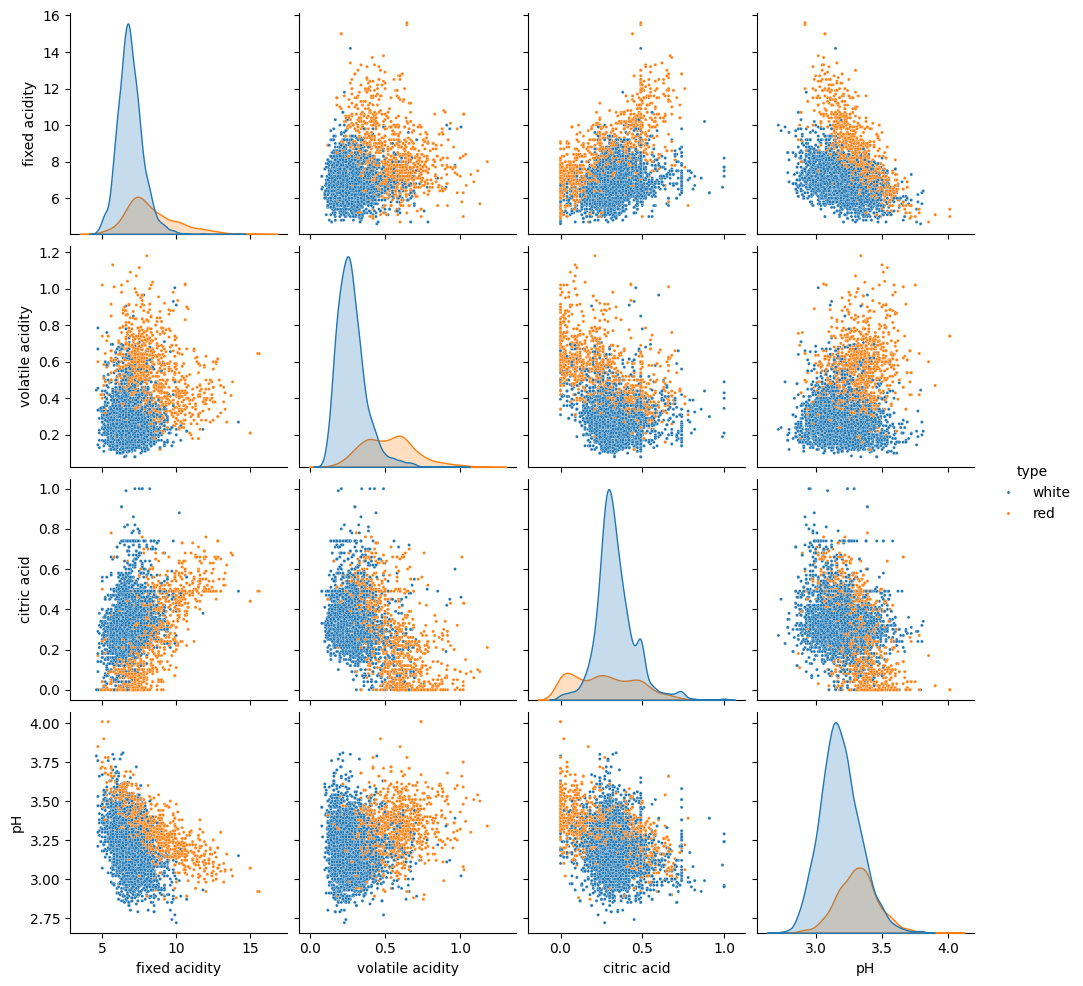

In [219]:
fig = sns.pairplot(
    train_set[["fixed acidity", "volatile acidity", "citric acid", "pH", "type"]],
    hue="type",
    plot_kws={"s": 5},
)
plt.show()

On observe que la majorité des surfaces sont intéréssantes mais la plus intéréssante est entre "fixed acidity" et "volatile acidity". On va visualiser sur des graphique 3D les surfaces les plus intéréssantes.

In [220]:
fig = px.scatter_3d(
    train_set,
    x="fixed acidity",
    y="volatile acidity",
    z="citric acid",
    color="type",
)
fig.update_traces(
    marker=dict(size=4, line=dict(width=2)),
    selector=dict(mode="markers"),
)
fig.update_layout(
    title_text="Relation entre l'acidité fixe, l'acidité volatile et la concentration en acide citrique pour les deux types de vins",
    title_x=0.5,
)

In [221]:
fig = px.scatter_3d(
    train_set,
    x="fixed acidity",
    y="volatile acidity",
    z="pH",
    color="type",
)
fig.update_traces(
    marker=dict(size=4, line=dict(width=2)),
    selector=dict(mode="markers"),
)
fig.update_layout(
    title_text="Relation entre l'acidité fixe, l'acidité volatile et la concentration en acide citrique pour les deux types de vins",
    title_x=0.5,
)

In [222]:
fig = px.scatter_3d(
    train_set,
    x="fixed acidity",
    y="citric acid",
    z="pH",
    color="type",
)
fig.update_traces(
    marker=dict(size=4, line=dict(width=2)),
    selector=dict(mode="markers"),
)
fig.update_layout(
    title_text="Relation entre l'acidité fixe, l'acidité volatile et la concentration en acide citrique pour les deux types de vins",
    title_x=0.5,
)

On voit qu'on peut faire trois surface avec lesquelles on peut faire des modéles assez bon. Maintenant essayons de regarder les relations entre les variables intéréssantes et les variables d'acidité.

### II.3.4) Relation entre les variables intéréssante et d'acidité

Au lieu de visualiser toutes les relations, on peut regarder directement la relation 2D entre la concentration total en S02 et l'acidité volatile qui constitue les deux meilleurs variables jusqu'à maintenant.

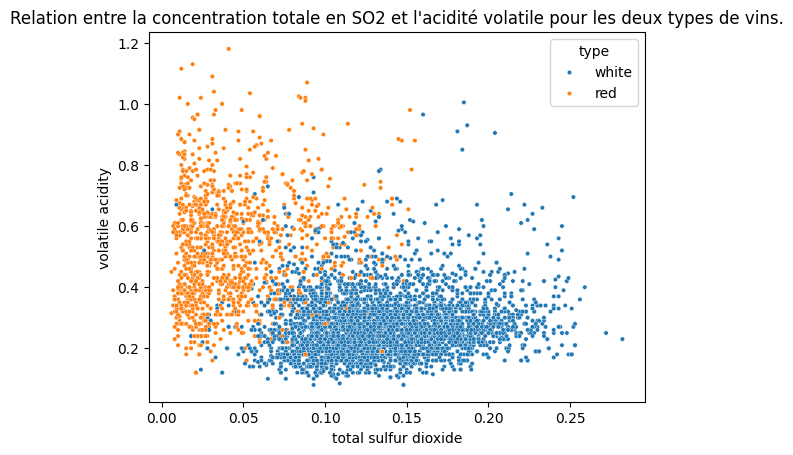

In [223]:
sns.scatterplot(
    data=train_set, x="total sulfur dioxide", y="volatile acidity", hue="type", s=10
)
plt.title(
    "Relation entre la concentration totale en SO2 et l'acidité volatile pour les deux types de vins."
)
plt.show()

On voit qu'on peut clairement faire un modéle performant avec cette surface mais avant il nous reste à analyser les deux derniére variables qui sont la concentration en NaCl et la densité.

## II.4) Analyse de la concentration en NaCl et de la densité.

### II.4.1) Analyse univarié

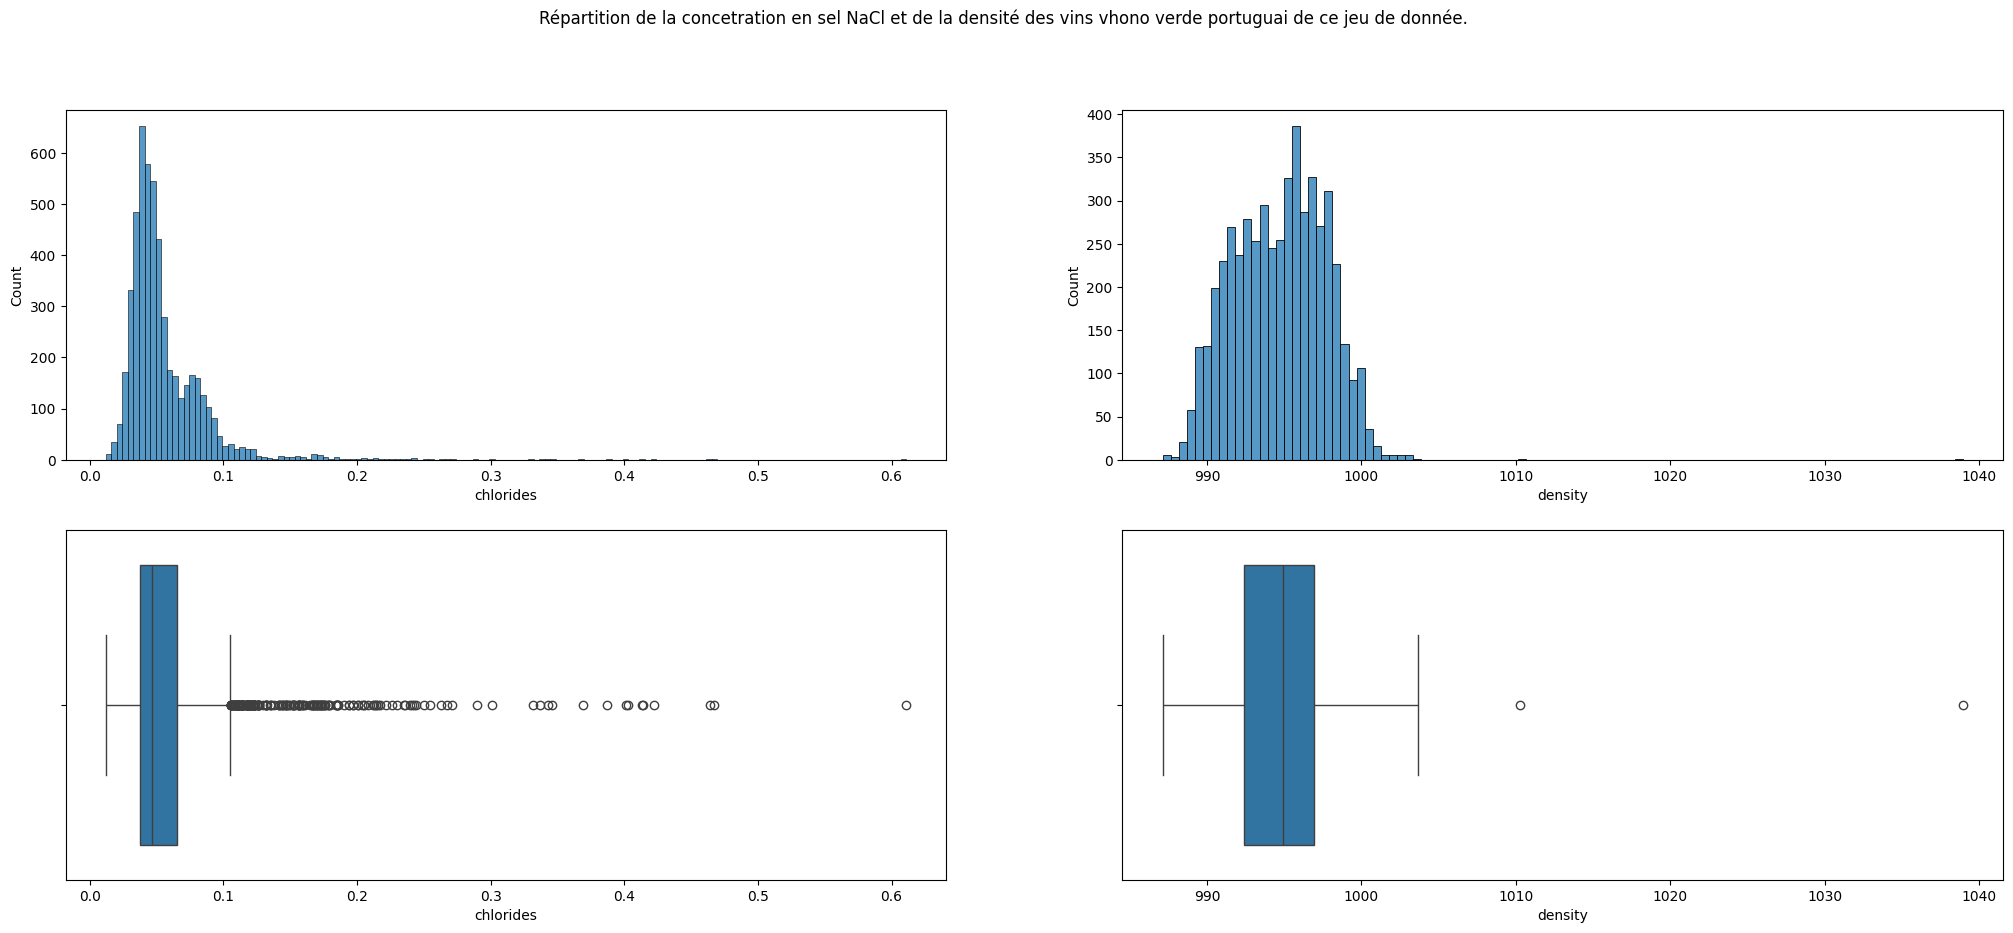

,chlorides,density
count,5154.000000,5154.000000
mean,0.055808,994.694292
std,0.033587,2.987132
min,0.012000,987.110000
25%,0.038000,992.370000
50%,0.047000,994.900000
75%,0.065000,996.920000
max,0.611000,1038.980000


In [224]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(25, 10)
plt.suptitle(
    "Répartition de la concetration en sel NaCl et de la densité des vins vhono verde portuguai de ce jeu de donnée."
)
sns.histplot(data=train_set, x="chlorides", ax=ax[0, 0])
sns.boxplot(data=train_set, x="chlorides", ax=ax[1, 0])
sns.histplot(data=train_set, x="density", ax=ax[0, 1])
sns.boxplot(data=train_set, x="density", ax=ax[1, 1])
plt.show()
train_set[["chlorides", "density"]].describe()

Les vins vhino verde portugai de ce jeu de données ont en moyenne 0.056 g/l de sel NaCl et une densité moyenne de 994.694 g/l qui est assez proche de celle de l'eau (1000 g/l). Les deux variables suivent clairement une loi normale avec une série d'outliers pour la concentration en sel et seulement deux outliers pour la densité.

### II.4.2) Analyse avec le type de vin

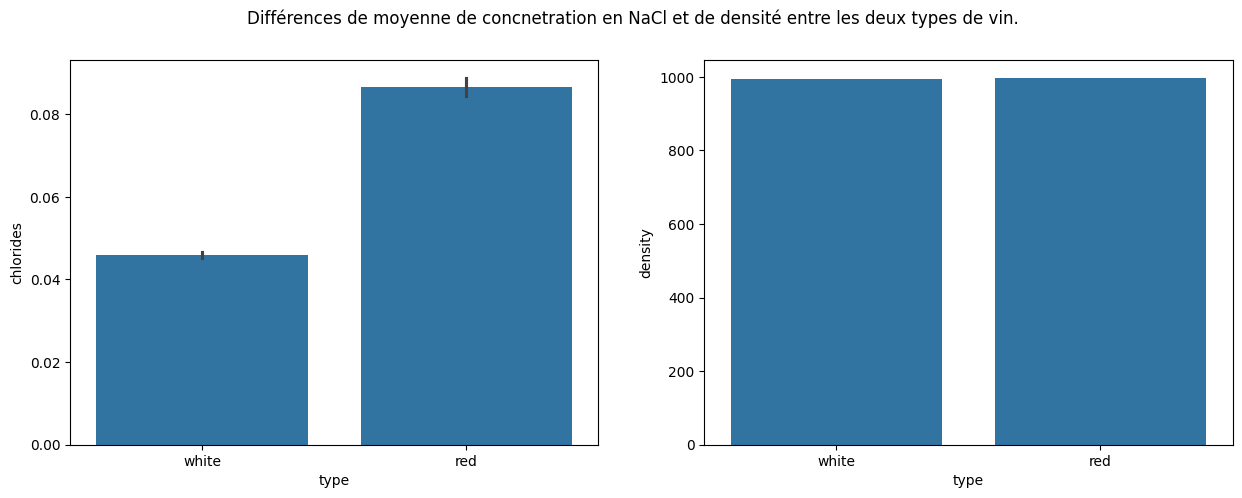

In [225]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)
plt.suptitle(
    "Différences de moyenne de concnetration en NaCl et de densité entre les deux types de vin."
)
sns.barplot(data=train_set, y="chlorides", x="type", ax=ax[0])
sns.barplot(data=train_set, y="density", x="type", ax=ax[1])
plt.show()

On remarque que les vins blanc ont en moyenne moins de sel que les vins rouges et que les densité sans surprise sont équivalent.

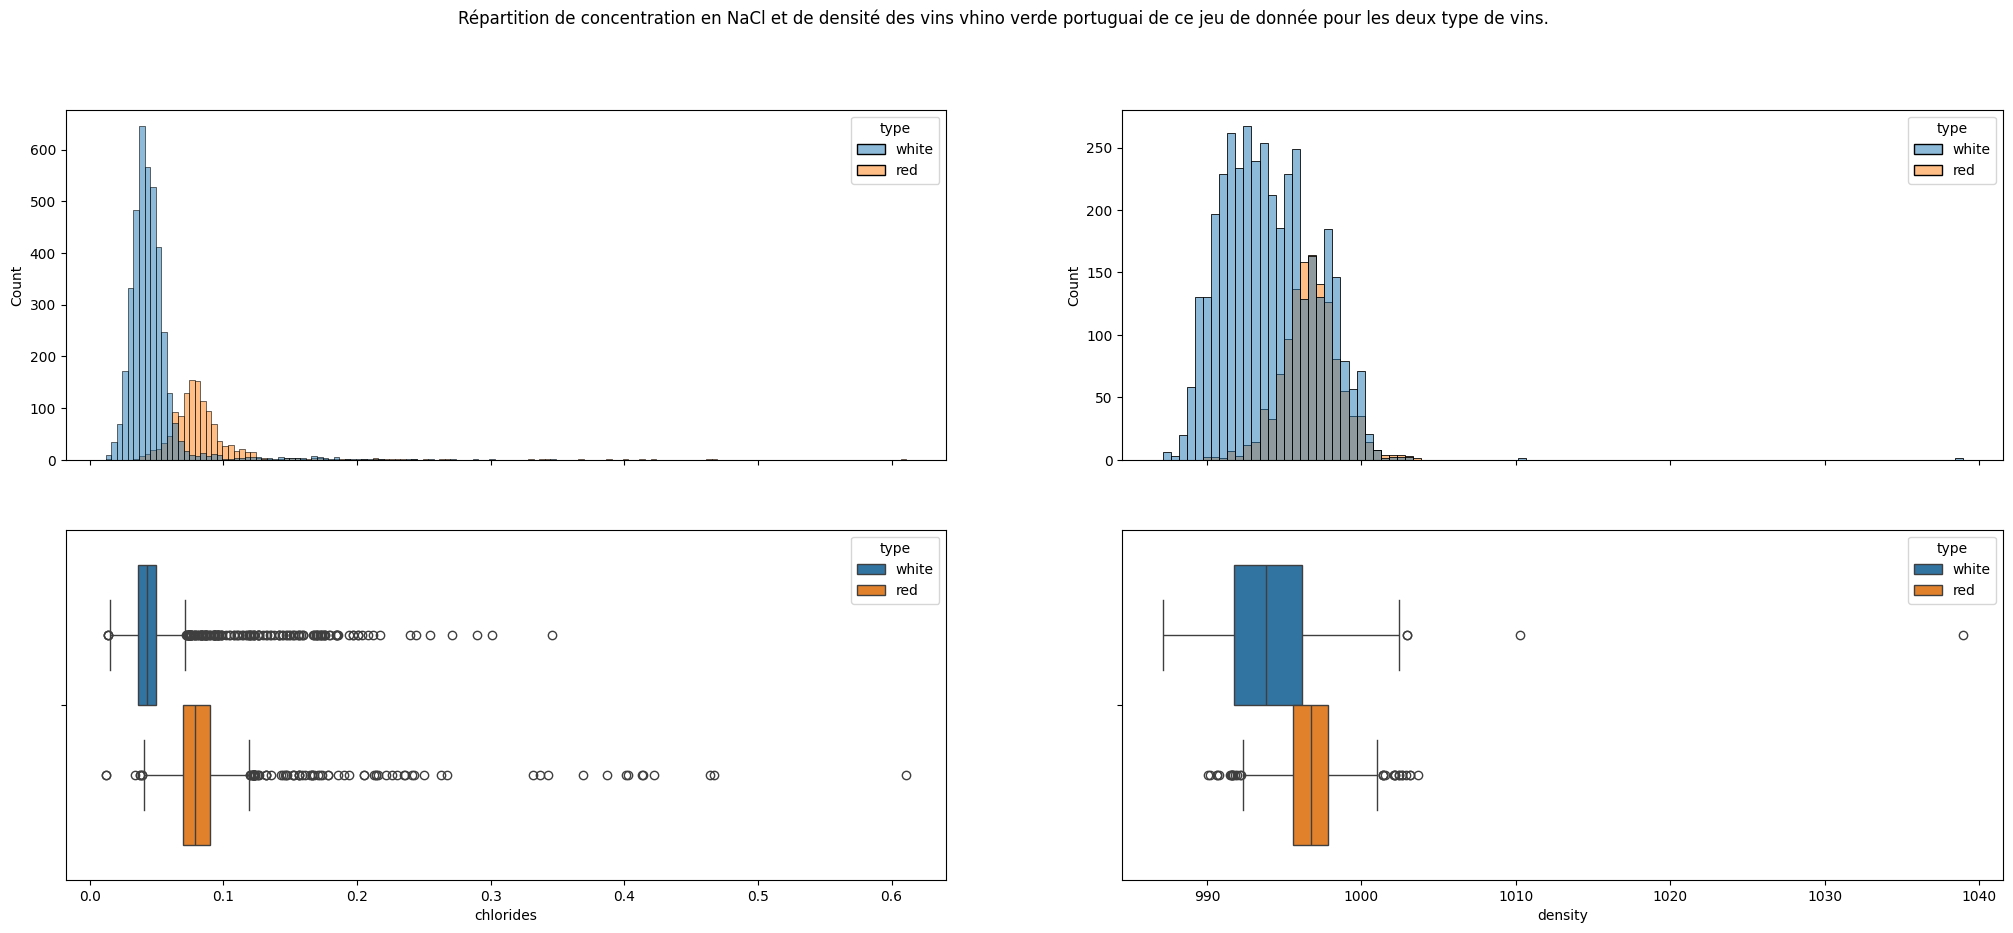

In [226]:
fig, ax = plt.subplots(2, 2, sharex="col")
fig.set_size_inches(25, 10)
plt.suptitle(
    "Répartition de concentration en NaCl et de densité des vins vhino verde portuguai de ce jeu de donnée pour les deux type de vins."
)
sns.histplot(data=train_set, x="chlorides", hue="type", ax=ax[0, 0])
sns.boxplot(data=train_set, x="chlorides", hue="type", ax=ax[1, 0])
sns.histplot(data=train_set, x="density", hue="type", ax=ax[0, 1])
sns.boxplot(data=train_set, x="density", hue="type", ax=ax[1, 1])
plt.show()

On voit qu'il y a un décalage des deux distributions pour les deux variables même si ce décalage est vraiment présent pour la concentration en sel. Elle constitue aussi une variable trés importante pour le modéle. Testons les différences de moyenne avec un test de student.

In [227]:
train_set.groupby("type")[["chlorides", "density"]].std()

,chlorides,density
type,,
red,0.043146,1.843609
white,0.022206,2.994326


On voit que les écart-type sont assez similaire pour utilise un test de student.

In [228]:
print(
    "H0: Les vins rouge ont en moyenne la même concnetration en NaCl que les vins blanc."
)

alpha = 0.02

p_value = ttest_ind(
    train_set.query("`type` == 'red'")["chlorides"],
    train_set.query("`type` == 'white'")["chlorides"],
    equal_var=False,
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les vins rouge ont en moyenne la même concnetration en NaCl que les vins blanc.
Nous avons assez d'évidence pour rejeter H0.


In [229]:
print("H0: Les vins rouge ont en moyenne la même densité que les vins blanc.")

alpha = 0.02

p_value = ttest_ind(
    train_set.query("`type` == 'red'")["density"],
    train_set.query("`type` == 'white'")["density"],
    equal_var=False,
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les vins rouge ont en moyenne la même densité que les vins blanc.
Nous avons assez d'évidence pour rejeter H0.


On a réussie à rejeter H0 pour les deux variables et donc les différences sont significatifs.

### II.4.3) Analyse des meilleurs variables entre-eux.

Au lieu de regarder toutes les relations, on va toutes de suite regarder les meilleurs variables entre-eux.

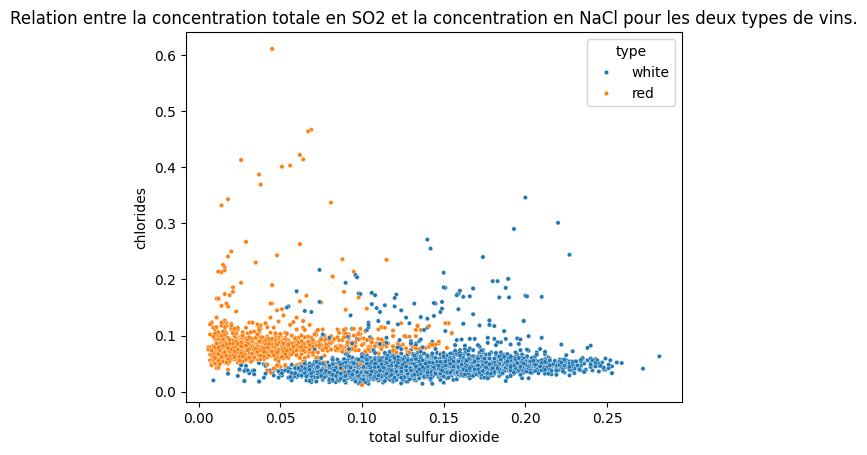

In [230]:
sns.scatterplot(
    data=train_set, x="total sulfur dioxide", y="chlorides", hue="type", s=10
)
plt.title(
    "Relation entre la concentration totale en SO2 et la concentration en NaCl pour les deux types de vins."
)
plt.show()

Cette surface est vraiment intéréssante car on voit que la plupart des vins rouge sont séparé des vins blanc par une droite même si les deux nuage sont proches. En conclusion seul le degré d'alcool n'est pas intéréssant et on a trouver de nombreuse relation intéréssante. Il faut savoir que seul les mesures obligatoire sont les mesures en acidité fixe, volatile, de la concentration en acide citrique, de la concentration de sucre résiduelle, de la concentration en NaCl, de la concentration en SO2 totale, de la concentration en sulfates et en alcool. Il faut savoir que dans ce type de ligne de production on mesure aussi la température et l'analyse du est fait en même temps et la mesure de densité est trés rapide avec des cout trés petit. Par conséquent comme notre objectif est aussi de minimiser les cout en analyses, on va faire un premier modéle avec les variables associé aux analyses physico-chimique obligatoire et si l'objectif n'est pas atteint on pourrat rajouté la densité et le pH. 

# III) Premier modéle

In [ ]:
X_train = train_set.drop(
    ["type", "alcohol", "pH", "density", "free sulfur dioxide"], axis=1
)
y_train = train_set["type"]
X_test = test_set.drop(
    ["type", "alcohol", "pH", "density", "free sulfur dioxide"], axis=1
)
y_test = test_set["type"]
X_train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,total sulfur dioxide,sulphates
2618,8.3,0.14,0.26,1.5,0.049,0.189,0.62
2359,6.9,0.18,0.38,8.1,0.049,0.176,0.54
4924,6.8,0.25,0.28,5.0,0.035,0.126,0.38
6351,5.1,0.25,0.36,1.3,0.035,0.078,0.64
153,7.5,0.60,0.03,1.8,0.095,0.099,0.54
...,...,...,...,...,...,...,...
3803,7.6,0.27,0.33,2.0,0.059,0.175,0.56
5232,6.6,0.30,0.25,8.0,0.036,0.124,0.38
5267,6.5,0.27,0.26,11.0,0.030,0.082,0.36
5431,6.8,0.31,0.19,3.5,0.086,0.130,0.44


On voit que c'est la surface entre l'acidité volatile et la concentration totale en SO2 qui est la meilleur surface. On va donc essayer un premier modéle avec seulement ces deux variables. Avant on doit choisir les meilleurs méthodes de normalisation.

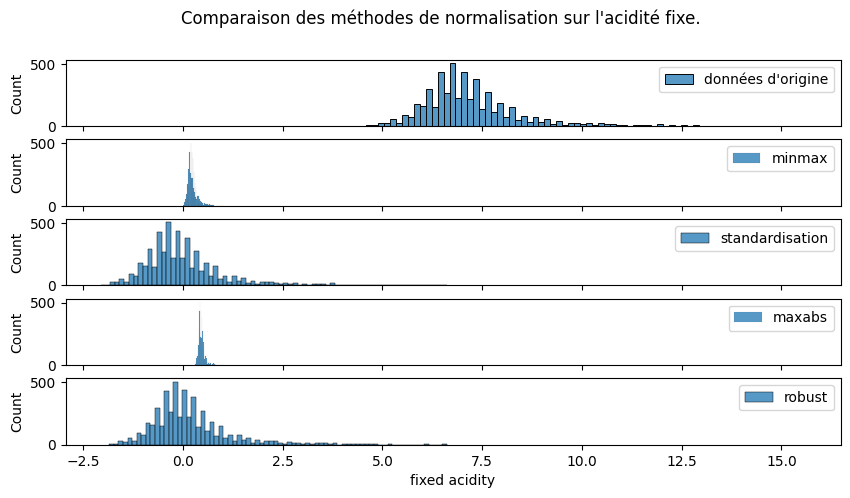

In [232]:
minmax = MinMaxScaler()
standard = StandardScaler()
maxabs = MaxAbsScaler()
robust = RobustScaler()

X_minmax = minmax.fit_transform(X_train)
X_standard = standard.fit_transform(X_train)
X_maxabs = maxabs.fit_transform(X_train)
X_robust = robust.fit_transform(X_train)

fig, ax = plt.subplots(5, 1, sharex=True)
fig.set_size_inches(10, 5)
plt.suptitle("Comparaison des méthodes de normalisation sur l'acidité fixe.")
sns.histplot(data=X_train, x="fixed acidity", label="données d'origine", ax=ax[0])
sns.histplot(data=X_minmax, x="fixed acidity", label="minmax", ax=ax[1])
sns.histplot(data=X_standard, x="fixed acidity", label="standardisation", ax=ax[2])
sns.histplot(data=X_maxabs, x="fixed acidity", label="maxabs", ax=ax[3])
sns.histplot(data=X_robust, x="fixed acidity", label="robust", ax=ax[4])
for axi in ax:
    axi.legend()
plt.show()

La standardisation est meilleur car elle ne compresse pas trop les données.

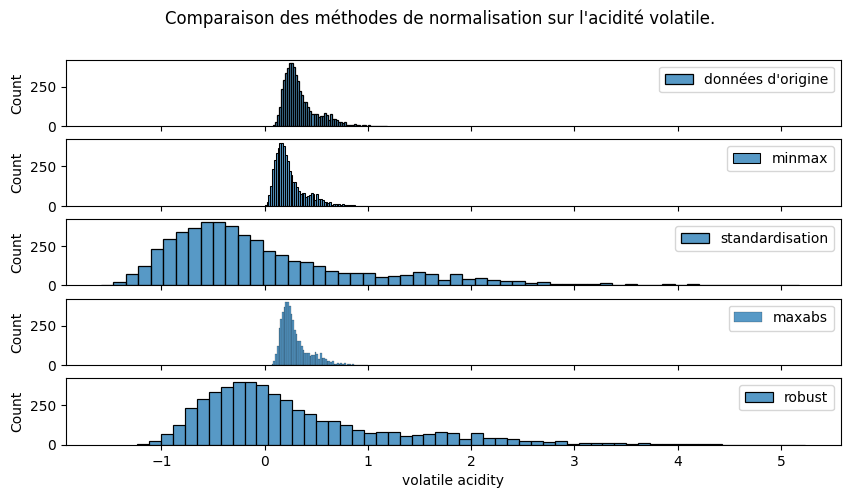

In [233]:
fig, ax = plt.subplots(5, 1, sharex=True)
fig.set_size_inches(10, 5)
plt.suptitle("Comparaison des méthodes de normalisation sur l'acidité volatile.")
sns.histplot(data=X_train, x="volatile acidity", label="données d'origine", ax=ax[0])
sns.histplot(data=X_minmax, x="volatile acidity", label="minmax", ax=ax[1])
sns.histplot(data=X_standard, x="volatile acidity", label="standardisation", ax=ax[2])
sns.histplot(data=X_maxabs, x="volatile acidity", label="maxabs", ax=ax[3])
sns.histplot(data=X_robust, x="volatile acidity", label="robust", ax=ax[4])
for axi in ax:
    axi.legend()
plt.show()

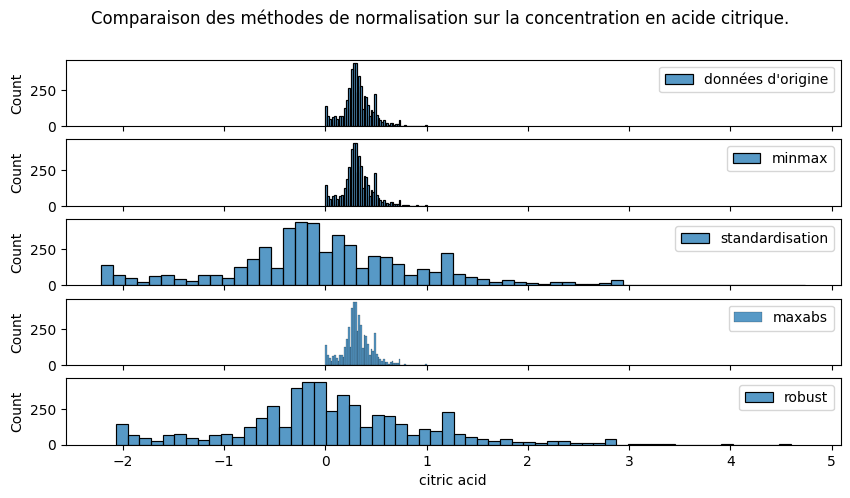

In [234]:
fig, ax = plt.subplots(5, 1, sharex=True)
fig.set_size_inches(10, 5)
plt.suptitle(
    "Comparaison des méthodes de normalisation sur la concentration en acide citrique."
)
sns.histplot(data=X_train, x="citric acid", label="données d'origine", ax=ax[0])
sns.histplot(data=X_minmax, x="citric acid", label="minmax", ax=ax[1])
sns.histplot(data=X_standard, x="citric acid", label="standardisation", ax=ax[2])
sns.histplot(data=X_maxabs, x="citric acid", label="maxabs", ax=ax[3])
sns.histplot(data=X_robust, x="citric acid", label="robust", ax=ax[4])
for axi in ax:
    axi.legend()
plt.show()

MinMax est meilleur car cette variable est déjà normaliser entre 0 et 1.

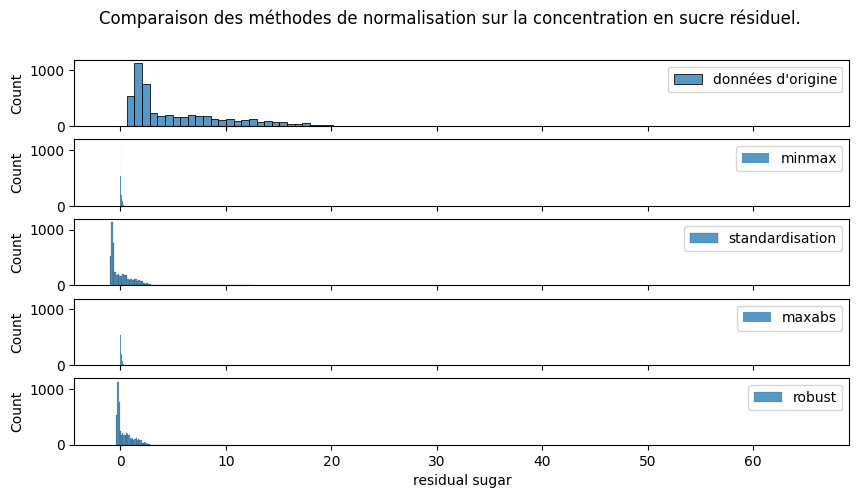

In [235]:
fig, ax = plt.subplots(5, 1, sharex=True)
fig.set_size_inches(10, 5)
plt.suptitle(
    "Comparaison des méthodes de normalisation sur la concentration en sucre résiduel."
)
sns.histplot(data=X_train, x="residual sugar", label="données d'origine", ax=ax[0])
sns.histplot(data=X_minmax, x="residual sugar", label="minmax", ax=ax[1])
sns.histplot(data=X_standard, x="residual sugar", label="standardisation", ax=ax[2])
sns.histplot(data=X_maxabs, x="residual sugar", label="maxabs", ax=ax[3])
sns.histplot(data=X_robust, x="residual sugar", label="robust", ax=ax[4])
for axi in ax:
    axi.legend()
plt.show()

Toutes les méthodes compresse les données. La méthodes qui compresse le moins est la standardisation.

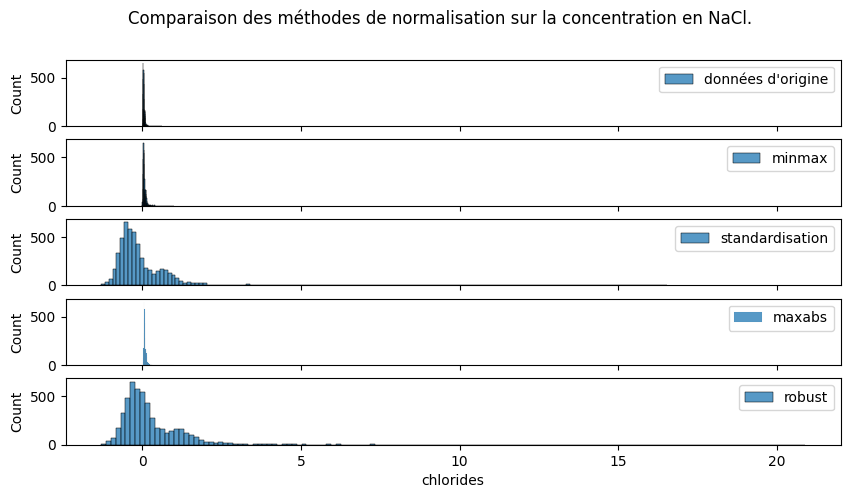

In [236]:
fig, ax = plt.subplots(5, 1, sharex=True)
fig.set_size_inches(10, 5)
plt.suptitle("Comparaison des méthodes de normalisation sur la concentration en NaCl.")
sns.histplot(data=X_train, x="chlorides", label="données d'origine", ax=ax[0])
sns.histplot(data=X_minmax, x="chlorides", label="minmax", ax=ax[1])
sns.histplot(data=X_standard, x="chlorides", label="standardisation", ax=ax[2])
sns.histplot(data=X_maxabs, x="chlorides", label="maxabs", ax=ax[3])
sns.histplot(data=X_robust, x="chlorides", label="robust", ax=ax[4])
for axi in ax:
    axi.legend()
plt.show()

MinMax est meilleur.

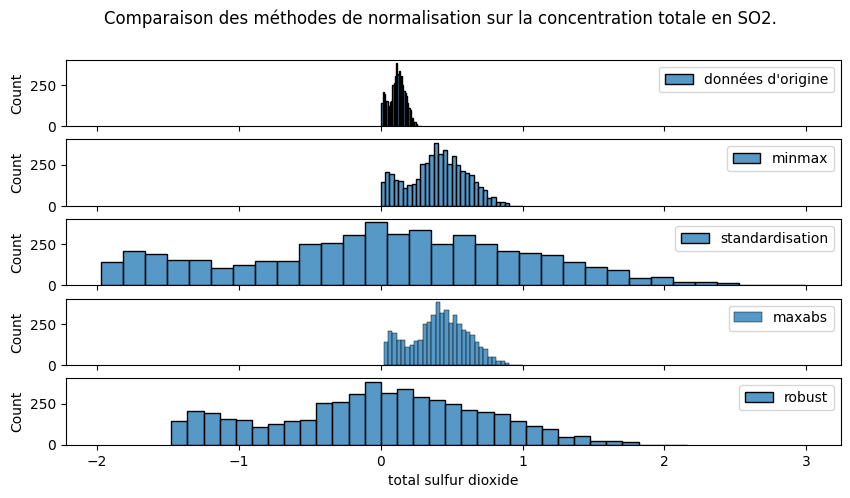

In [237]:
fig, ax = plt.subplots(5, 1, sharex=True)
fig.set_size_inches(10, 5)
plt.suptitle(
    "Comparaison des méthodes de normalisation sur la concentration totale en SO2."
)
sns.histplot(
    data=X_train, x="total sulfur dioxide", label="données d'origine", ax=ax[0]
)
sns.histplot(data=X_minmax, x="total sulfur dioxide", label="minmax", ax=ax[1])
sns.histplot(
    data=X_standard, x="total sulfur dioxide", label="standardisation", ax=ax[2]
)
sns.histplot(data=X_maxabs, x="total sulfur dioxide", label="maxabs", ax=ax[3])
sns.histplot(data=X_robust, x="total sulfur dioxide", label="robust", ax=ax[4])
for axi in ax:
    axi.legend()
plt.show()

MinMax est meilleur.

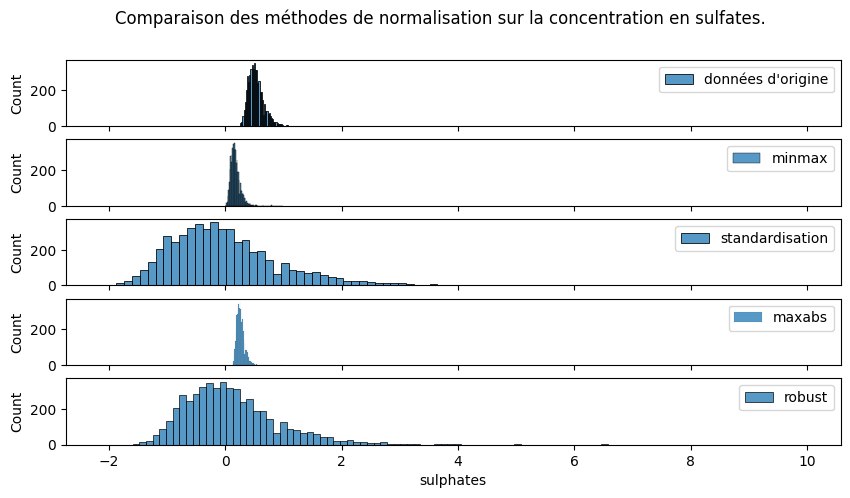

In [238]:
fig, ax = plt.subplots(5, 1, sharex=True)
fig.set_size_inches(10, 5)
plt.suptitle(
    "Comparaison des méthodes de normalisation sur la concentration en sulfates."
)
sns.histplot(data=X_train, x="sulphates", label="données d'origine", ax=ax[0])
sns.histplot(data=X_minmax, x="sulphates", label="minmax", ax=ax[1])
sns.histplot(data=X_standard, x="sulphates", label="standardisation", ax=ax[2])
sns.histplot(data=X_maxabs, x="sulphates", label="maxabs", ax=ax[3])
sns.histplot(data=X_robust, x="sulphates", label="robust", ax=ax[4])
for axi in ax:
    axi.legend()
plt.show()

MinMax est meilleur. Construisons le normaliseur.

In [239]:
normaliser = ColumnTransformer(
    [
        ("standard", StandardScaler(), ["fixed acidity", "residual sugar"]),
        (
            "minmax",
            MinMaxScaler(),
            [
                "volatile acidity",
                "citric acid",
                "chlorides",
                "total sulfur dioxide",
                "sulphates",
            ],
        ),
    ],
    verbose_feature_names_out=False,
)

In [240]:
pipeline = make_pipeline(normaliser)
pipeline

,steps,"[('columntransformer', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('standard', ...), ('minmax', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [241]:
X_train_preprocessed = pipeline.fit_transform(X_train)
X_train_preprocessed

,fixed acidity,residual sugar,volatile acidity,citric acid,chlorides,total sulfur dioxide,sulphates
2618,0.861406,-0.833135,0.054545,0.26,0.061770,0.663043,0.227273
2359,-0.244664,0.544944,0.090909,0.38,0.061770,0.615942,0.181818
4924,-0.323669,-0.102336,0.154545,0.28,0.038397,0.434783,0.090909
6351,-1.666755,-0.874895,0.154545,0.36,0.038397,0.260870,0.238636
153,0.229366,-0.770496,0.472727,0.03,0.138564,0.336957,0.181818
...,...,...,...,...,...,...,...
3803,0.308371,-0.728736,0.172727,0.33,0.078464,0.612319,0.193182
5232,-0.481679,0.524064,0.200000,0.25,0.040067,0.427536,0.090909
5267,-0.560684,1.150463,0.172727,0.26,0.030050,0.275362,0.079545
5431,-0.323669,-0.415536,0.209091,0.19,0.123539,0.449275,0.125000


In [242]:
param_grid = {
    "solver": ["lbfgs", "newton-cg", "sag", "saga"],  # compatibles avec penalty="none"
    "multi_class": ["auto", "multinomial", "ovr"],
    "class_weight": [None, "balanced"],
    "fit_intercept": [True, False],
    "warm_start": [False, True],
}

f1_red = make_scorer(f1_score, average="binary", pos_label="red", zero_division=0)

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

grid = GridSearchCV(
    estimator=LogisticRegression(random_state=42, n_jobs=-1, penalty=None),
    param_grid=param_grid,
    cv=cv,
    scoring=f1_red,
    n_jobs=-1,
)

grid.fit(X_train_preprocessed, y_train)
print(grid.best_params_)
print(grid.best_score_)
model = grid.best_estimator_
print("f1: ", f1_red(model, X_train_preprocessed, y_train))
print(
    "acuracy: ",
    accuracy_score(y_pred=model.predict(X_train_preprocessed), y_true=y_train),
)
recall_red = make_scorer(
    recall_score, average="binary", pos_label="red", zero_division=0
)
precision_red = make_scorer(
    precision_score, average="binary", pos_label="red", zero_division=0
)
rocauc_red = make_scorer(
    roc_auc_score, average="binary", pos_label="red", zero_division=0
)
print("recall: ", recall_red(model, X_train_preprocessed, y_train))
print("precision: ", precision_red(model, X_train_preprocessed, y_train))
y_score = model.predict_proba(X_train_preprocessed)
print("rocAuc: ", roc_auc_score(y_train, y_score[:, 1]))

/home/florian/WineTypePrediction/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/florian/WineTypePrediction/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/florian/WineTypePrediction/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/florian/WineTypePrediction/.venv/lib/python3.13/site-pa

{'class_weight': None, 'fit_intercept': True, 'multi_class': 'multinomial', 'solver': 'sag', 'warm_start': False}
0.9651682122177323
f1:  0.9639711769415532
acuracy:  0.9825378346915018
recall:  0.9624300559552358
precision:  0.9655172413793104
rocAuc:  0.9961772831286597


/home/florian/WineTypePrediction/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/florian/WineTypePrediction/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/florian/WineTypePrediction/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/florian/WineTypePrediction/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated i

On voit que sur le train set pour toutes les métriques on a des score haut mais pas assez élevé. Regardons sur le jeu de test.

In [243]:
X_test_norm = pipeline.transform(X_test)
print("f1: ", f1_red(model, X_test_norm, y_test))
print("acuracy: ", accuracy_score(y_pred=model.predict(X_test_norm), y_true=y_test))
print("recall: ", recall_red(model, X_test_norm, y_test))
print("precision: ", precision_red(model, X_test_norm, y_test))
y_score = model.predict_proba(X_test_norm)
print("rocAuc: ", roc_auc_score(y_test, y_score[:, 1]))

f1:  0.9715994020926756
acuracy:  0.9852598913886734
recall:  0.9615384615384616
precision:  0.9818731117824774
rocAuc:  0.9952899159402436


On voit qu'on a atteint notre objectif pour les métriques suivantes:

-Accuraccy

-rocAuc

On doit donc améliorer notre modéle sur les autres métriques. On va donc devoir rajouter la densité et le pH.

# IV) Deuxiéme modéle: ajout du pH et de la densité.